## Library

In [1]:
import os
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
from datetime import datetime as dt
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 5000                                       # Number of runs to do (default 10000)
CURRENT_YEAR = 2023                               # What year to start the run on? (default: 2023)
MAX_YEAR = CURRENT_YEAR + 100                     # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/pasta')  # Cache generated in "Anchors" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/pasta.sqcache.npy'))))
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

Cache from: 2023-07-09 21:08:13.276039


{1: 23.4,
 5: 24.7,
 10: 25.4,
 20: 26.3,
 30: 27.1,
 40: 27.9,
 50: 29.4,
 60: 31.1,
 70: 33.1,
 80: 35.5,
 90: 38.9,
 95: 41.7,
 99: 47.301000000000016}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "Initial pay" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/initial_pay.sqcache.npy'))))
initial_pay = [round(p, 1) for p in initial_pay]
# TODO: Suspicious this is not working in the model correctly
sq.get_percentiles(initial_pay)

Cache from: 2023-09-25 10:38:16.758663


{1: 8.0,
 5: 8.2,
 10: 8.3,
 20: 8.4,
 30: 8.5,
 40: 8.6,
 50: 8.6,
 60: 8.7,
 70: 8.8,
 80: 8.9,
 90: 9.1,
 95: 9.2,
 99: 9.5}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/nonscaling_delays.dill'))))

delay

Cache from: 2023-09-05 17:35:37.520277


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=4.37, lognorm_sd=1.93, norm_mean=1.39, norm_sd=0.42)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=9.15, lognorm_sd=5.75, norm_mean=2.05, norm_sd=0.58)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=12.12, lognorm_sd=9.64, norm_mean=2.25, norm_sd=0.7)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lo

In [6]:
def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (4*K), 1 / (1*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.1:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.7:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.9:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.95, lclip=0.1, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.99, lclip=0.1, rclip=0.999)
        
    models_trained_per_year_for_budget = sq.lognorm(1, 10)

    frac = ~gdp_frac * ~percent_spent_on_compute / ~models_trained_per_year_for_budget
    
    return (1 / (4*K)) if frac < (1 / (4*K)) else frac


# https://forum.effectivealtruism.org/posts/ccw9v9giKxg8nyLhp/xpt-forecasts-on-some-biological-anchors-inputs
variables = {'initial_gdp': 23*T,
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': 3,
             'algo_doubling_rate_min': 1,
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': sq.lognorm(18, 19.2),
             'flop_halving_rate': sq.lognorm(1.4, 4.1),     # https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.lognorm(21, 26),  # https://epochai.org/blog/predicting-gpu-performance and https://asteriskmag.com/issues/03/the-transistor-cliff
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': wildeford_max_gdp_frac, # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.lognorm(1, 8.5, lclip=0.9),
             '2025_spend_doubling_time': sq.norm(0.94, 1.02, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

In [7]:
gdp_frac_samples = sq.sample(wildeford_max_gdp_frac, verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 1114380.15it/s]


{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00031,
 50: 0.00039,
 60: 0.0005,
 70: 0.00068,
 80: 0.00101,
 90: 0.00197,
 95: 0.00363,
 99: 0.00764}

In [8]:
gdp_samples = [g * variables['initial_gdp'] for g in gdp_frac_samples]
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '6 billion',
 5: '6 billion',
 10: '6 billion',
 20: '6 billion',
 30: '6 billion',
 40: '7 billion',
 50: '9 billion',
 60: '12 billion',
 70: '16 billion',
 80: '23 billion',
 90: '45 billion',
 95: '83 billion',
 99: '176 billion'}

## Run Wildeford timelines model

-
-
## SAMPLE RUN 1 ##
It takes 26.9 log FLOP (~794 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.9 log FLOP (~8 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~42 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~461 million). This doubles every 3.0 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.028x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 26.9 log FLOP (794 septillion) - log $ 8.0 to buy TAI (98 million) vs. willingness to pay log $ 8.6 (427 million) - 18.9 log FLOP per $ (8 quintillion) (Effective 2023-logFLOP: 27.5)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.0

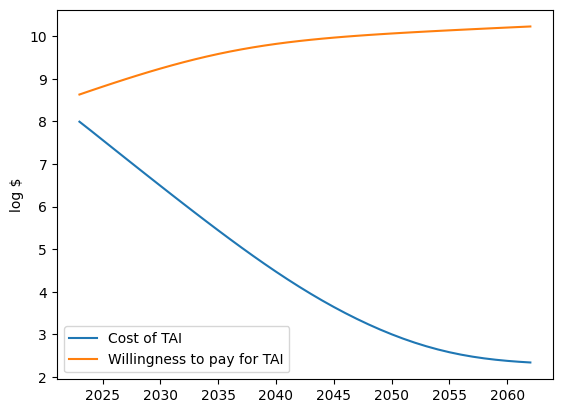

-
-
## SAMPLE RUN 2 ##
It takes 28.0 log FLOP (~10 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.2 log FLOP (~17 quintillion) per 2022$USD. Every 3.4 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~74 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~395 million). This doubles every 6.7 years to a max of 0.222761% of GDP (initially ~51 billion 2022$USD). GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 27.8 max log FLOP (7 octillion) available - TAI takes 28.0 log FLOP (10 octillion) - log $ 8.8 to buy TAI (584 million) vs. willingness to pay log $ 8.6 (392 million) - 19.2 log FLOP per $ (17 quintillion) (Effective 2023-logFLOP: 27.8)
Year: 2024 - 28.0 max log FLOP (9 octillion) available - TAI takes 27.9 log FLOP (8 octillion) - log $ 8.6 to buy TAI (383 million) vs. willingness to pay log $ 8.6 (434 million) - 19.3 log FLOP per $ (21 quintil

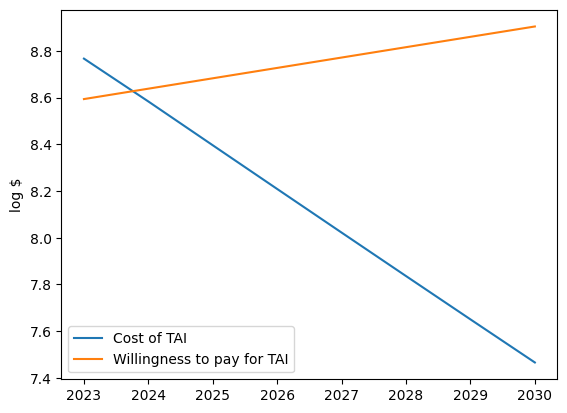

-
-
## SAMPLE RUN 3 ##
It takes 34.7 log FLOP (~50 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.8 log FLOP (~7 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 1.9 years to a max of 0.025388% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 34.7 log FLOP (50 decillion) - log $ 15.9 to buy TAI (7 quadrillion) vs. willingness to pay log $ 8.4 (231 million) - 18.8 log FLOP per $ (7 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.5 max log FLOP (3 octillion) available - TAI takes 34.5 log FLOP (32 decillion) - log $ 15.5 to buy TAI (3 quadrillion) vs. willingness to pay log $ 8.5 (331 million) - 19.0 log FLOP per $ (9 quinti

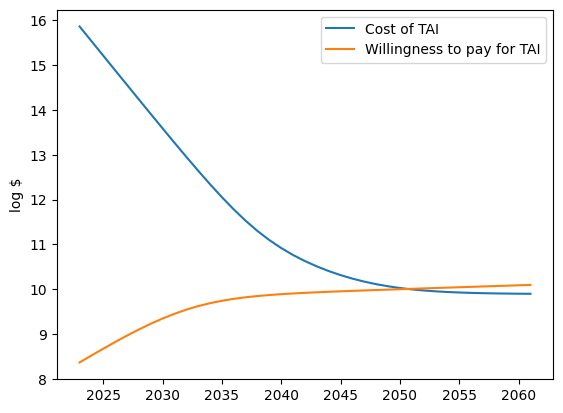

-
-
## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 306.29it/s]


Shuffling data...
Writing data...
Waiting for other cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 118.59it/s]

...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2031',
 '10%: 2033',
 '15%: 2034',
 '20%: 2035',
 '25%: 2037',
 '35%: 2039',
 '50%: 2044',
 '60%: 2049',
 '75%: 2062',
 '80%: 2071',
 '90%: >2123',
 '95%: >2123']
(Mean: 2057)
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 8 years from now',
 '10%: 10 years from now',
 '15%: 11 years from now',
 '20%: 12 years from now',
 '25%: 14 years from now',
 '35%: 16 years from now',
 '50%: 21 years from now',
 '60%: 26 years from now',
 '75%: 39 years from now',
 '80%: 48 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 34 years from now)
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.0%
2024-2027: 0.3%
2028-2029: 2.2%
2030-2034: 14.0%
2035-2039: 19.0%
2040-2049: 25.9%
2050-2059: 12.0%
2060-2069: 5.7%
2070-2079: 3.2%
2080-2089: 1.5%
2090-2099: 1.7%
2100-2109: 0.

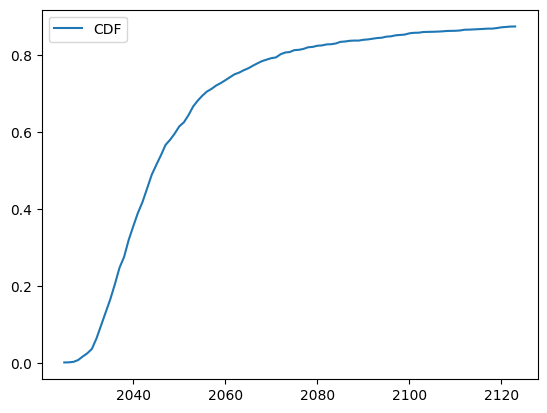

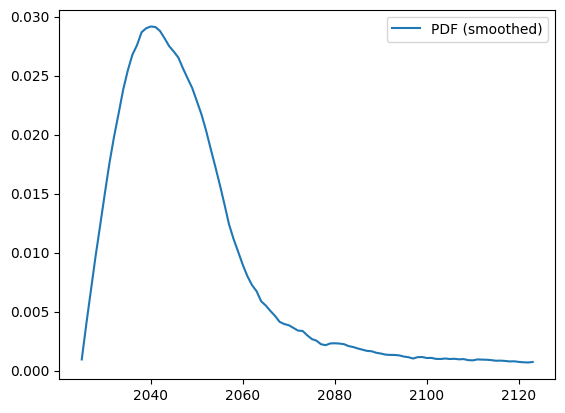

-
-
## TAI FLOP SIZE ##
{1: 23.3,
 5: 24.7,
 10: 25.4,
 20: 26.3,
 30: 27.1,
 40: 28.0,
 50: 29.7,
 60: 31.5,
 70: 33.4,
 80: 35.8,
 90: 39.1,
 95: 41.3,
 99: 46.0}
(Mean: 31.0)


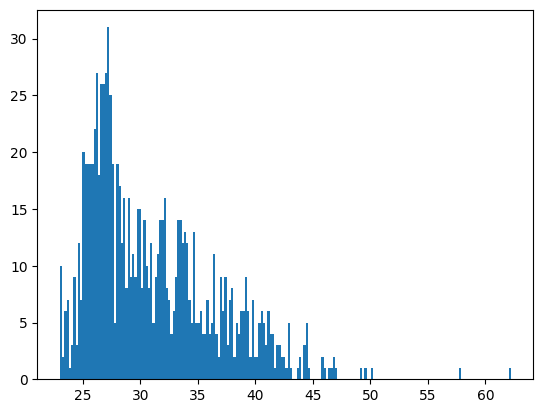

-
-
## MIN REDUCTION: 2 ##
-
## MAX REDUCTION ##
{1: 19.9,
 5: 14.5,
 10: 12.1,
 20: 10.0,
 30: 8.6,
 40: 7.6,
 50: 6.8,
 60: 6.0,
 70: 5.2,
 80: 4.5,
 90: 3.6,
 95: 2.9,
 99: 2.1}
(Mean: 7.5)


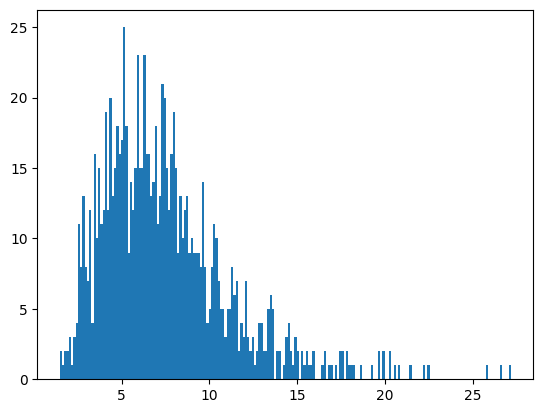

-
-
## MIN ALGO DOUBLING RATE: 1 ##
-
## MAX ALGO DOUBLING RATE: 3 ##
-
## INITIAL FLOP PER DOLLAR ##
{1: 17.8,
 5: 18.0,
 10: 18.1,
 20: 18.3,
 30: 18.4,
 40: 18.5,
 50: 18.6,
 60: 18.7,
 70: 18.8,
 80: 18.9,
 90: 19.1,
 95: 19.2,
 99: 19.4}
(Mean: 18.6)


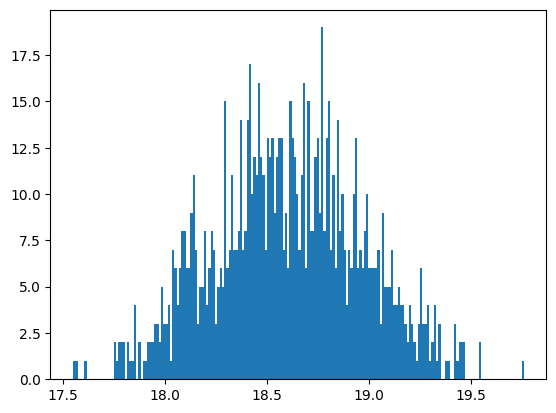

-
-
## FLOP HALVING RATE ##
{1: 4.8,
 5: 4.0,
 10: 3.6,
 20: 3.2,
 30: 2.9,
 40: 2.6,
 50: 2.4,
 60: 2.2,
 70: 2.0,
 80: 1.8,
 90: 1.7,
 95: 1.4,
 99: 1.2}
(Mean: 2.5)


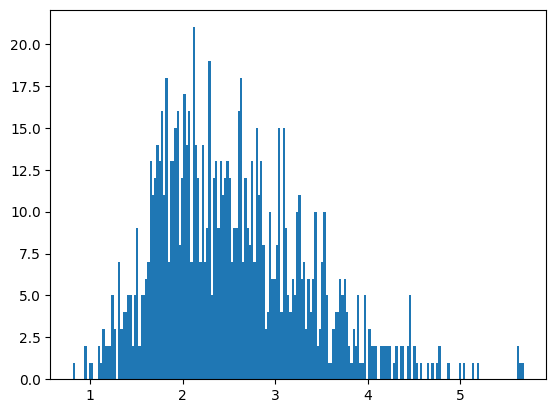

-
-
## MAX FLOP PER DOLLAR ##
{1: 20.4,
 5: 21.2,
 10: 21.6,
 20: 22.2,
 30: 22.6,
 40: 23.0,
 50: 23.4,
 60: 23.9,
 70: 24.3,
 80: 24.8,
 90: 25.5,
 95: 26.1,
 99: 27.2}
(Mean: 23.5)


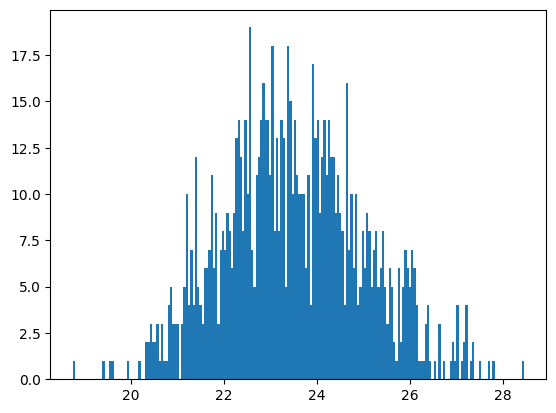

-
-
## INITIAL PAY ##
{1: 8.0,
 5: 8.2,
 10: 8.3,
 20: 8.4,
 30: 8.5,
 40: 8.6,
 50: 8.6,
 60: 8.7,
 70: 8.8,
 80: 8.9,
 90: 9.1,
 95: 9.2,
 99: 9.6}
(Mean: 8.7)


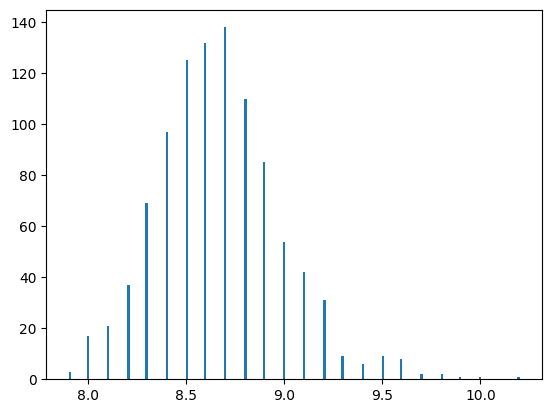

-
-
## GDP GROWTH ##
{1: 1.01,
 5: 1.01,
 10: 1.01,
 20: 1.02,
 30: 1.02,
 40: 1.02,
 50: 1.02,
 60: 1.02,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.03,
 99: 1.04}
(Mean: 1.0)


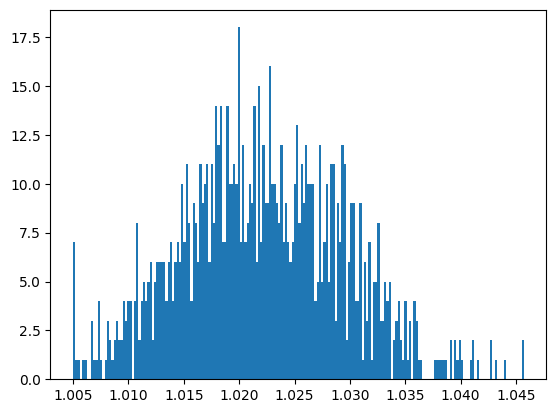

-
-
## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00031,
 50: 0.00039,
 60: 0.00051,
 70: 0.00069,
 80: 0.00102,
 90: 0.00223,
 95: 0.00399,
 99: 0.00979}
(Mean: 0.0)


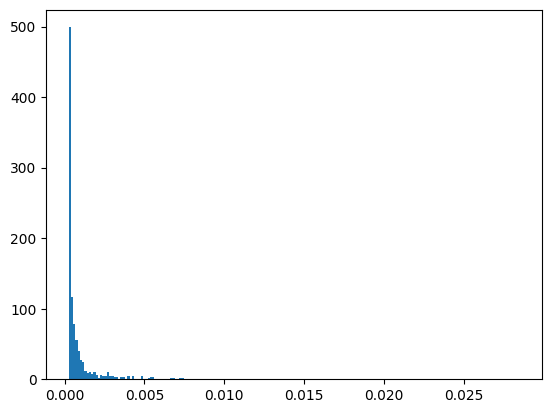

-
-
## SPEND DOUBLING TIME ##
{1: 11.8,
 5: 8.0,
 10: 6.5,
 20: 4.8,
 30: 4.1,
 40: 3.5,
 50: 2.9,
 60: 2.5,
 70: 2.0,
 80: 1.7,
 90: 1.2,
 95: 0.9,
 99: 0.9}
(Mean: 3.5)


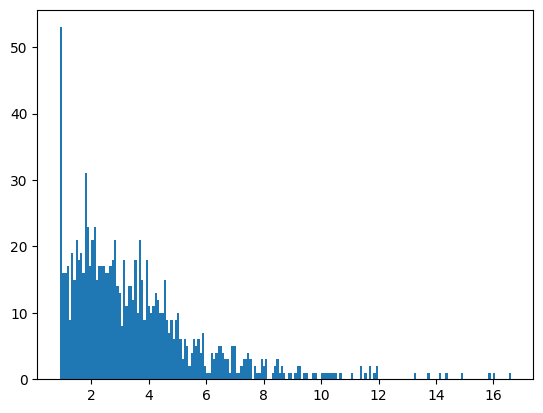

-
-
-
-
## GDP Over Time ##


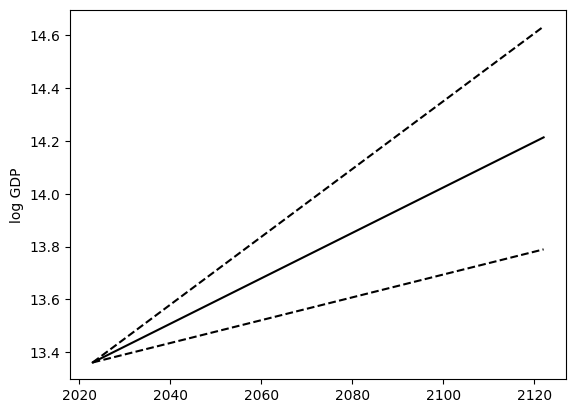

Year: 2023 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~23 trillion)
Year: 2024 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~25 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~26 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~28 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~29 trillion)
Year: 2032 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~30 trillion)
Year: 2033

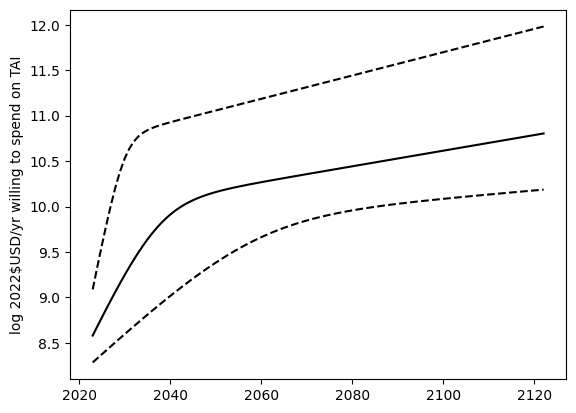

Year: 2023 - willingness log 2022$USD per year 8.6 (~381 million) 90% CI 8.3 (~193 million) - 9.1 (~1 billion)
Year: 2024 - willingness log 2022$USD per year 8.7 (~479 million) 90% CI 8.3 (~214 million) - 9.3 (~2 billion)
Year: 2025 - willingness log 2022$USD per year 8.8 (~601 million) 90% CI 8.4 (~237 million) - 9.6 (~4 billion)
Year: 2026 - willingness log 2022$USD per year 8.9 (~751 million) 90% CI 8.4 (~263 million) - 9.8 (~6 billion)
Year: 2027 - willingness log 2022$USD per year 9.0 (~936 million) 90% CI 8.5 (~291 million) - 10.0 (~10 billion)
Year: 2028 - willingness log 2022$USD per year 9.1 (~1 billion) 90% CI 8.5 (~322 million) - 10.2 (~16 billion)
Year: 2029 - willingness log 2022$USD per year 9.2 (~1 billion) 90% CI 8.6 (~356 million) - 10.4 (~24 billion)
Year: 2030 - willingness log 2022$USD per year 9.2 (~2 billion) 90% CI 8.6 (~394 million) - 10.5 (~34 billion)
Year: 2031 - willingness log 2022$USD per year 9.3 (~2 billion) 90% CI 8.6 (~436 million) - 10.6 (~43 billion)

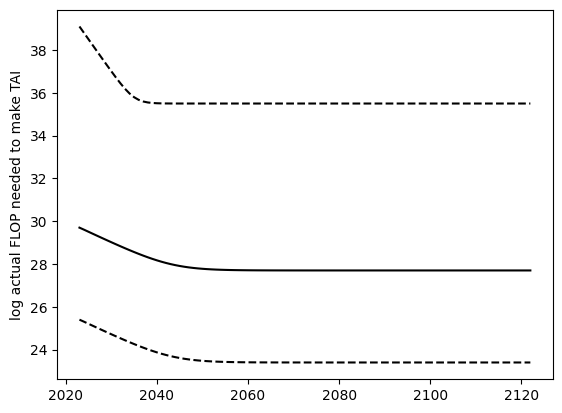

Year: 2023 - log FLOP needed for TAI 29.7 (~501 octillion) 90% CI 25.4 (~25 septillion) - 39.1 (~1 million decillion)
Year: 2024 - log FLOP needed for TAI 29.6 (~403 octillion) 90% CI 25.3 (~20 septillion) - 38.8 (~630 thousand decillion)
Year: 2025 - log FLOP needed for TAI 29.5 (~321 octillion) 90% CI 25.2 (~16 septillion) - 38.5 (~315 thousand decillion)
Year: 2026 - log FLOP needed for TAI 29.4 (~256 octillion) 90% CI 25.1 (~13 septillion) - 38.2 (~158 thousand decillion)
Year: 2027 - log FLOP needed for TAI 29.3 (~204 octillion) 90% CI 25.0 (~10 septillion) - 37.9 (~79 thousand decillion)
Year: 2028 - log FLOP needed for TAI 29.2 (~163 octillion) 90% CI 24.9 (~8 septillion) - 37.6 (~40 thousand decillion)
Year: 2029 - log FLOP needed for TAI 29.1 (~130 octillion) 90% CI 24.8 (~7 septillion) - 37.3 (~20 thousand decillion)
Year: 2030 - log FLOP needed for TAI 29.0 (~104 octillion) 90% CI 24.7 (~5 septillion) - 37.0 (~10 thousand decillion)
Year: 2031 - log FLOP needed for TAI 28.9 

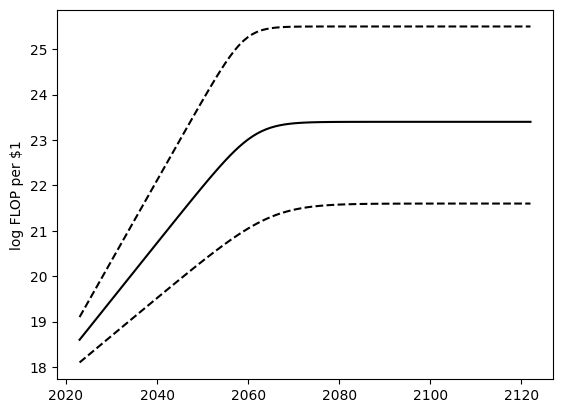

Year: 2023 - log FLOP per 2022$1USD 18.6 (~4 quintillion) 90% CI 18.1 (~1 quintillion) - 19.1 (~13 quintillion)
Year: 2024 - log FLOP per 2022$1USD 18.7 (~5 quintillion) 90% CI 18.2 (~2 quintillion) - 19.3 (~19 quintillion)
Year: 2025 - log FLOP per 2022$1USD 18.9 (~7 quintillion) 90% CI 18.3 (~2 quintillion) - 19.5 (~28 quintillion)
Year: 2026 - log FLOP per 2022$1USD 19.0 (~9 quintillion) 90% CI 18.4 (~2 quintillion) - 19.6 (~43 quintillion)
Year: 2027 - log FLOP per 2022$1USD 19.1 (~13 quintillion) 90% CI 18.4 (~3 quintillion) - 19.8 (~64 quintillion)
Year: 2028 - log FLOP per 2022$1USD 19.2 (~17 quintillion) 90% CI 18.5 (~3 quintillion) - 20.0 (~97 quintillion)
Year: 2029 - log FLOP per 2022$1USD 19.4 (~23 quintillion) 90% CI 18.6 (~4 quintillion) - 20.2 (~145 quintillion)
Year: 2030 - log FLOP per 2022$1USD 19.5 (~30 quintillion) 90% CI 18.7 (~5 quintillion) - 20.3 (~219 quintillion)
Year: 2031 - log FLOP per 2022$1USD 19.6 (~40 quintillion) 90% CI 18.8 (~6 quintillion) - 20.5 (~3

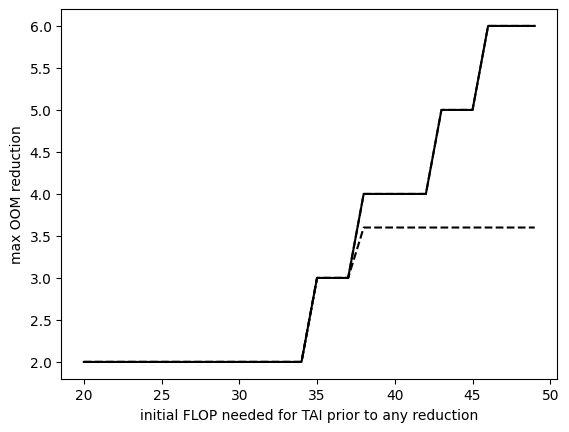

TAI log FLOP 20 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> 2.0 OOM reductions possible (

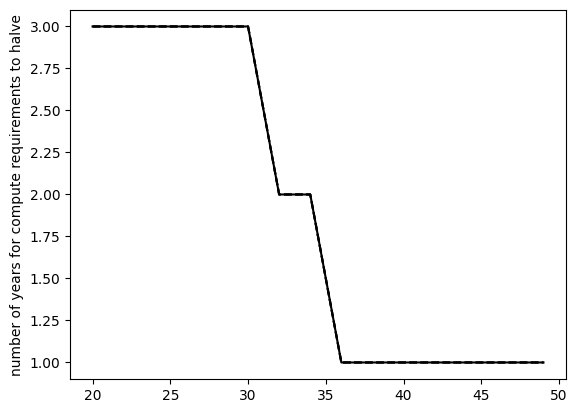

TAI log FLOP 20 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 21 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 22 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 23 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 24 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 25 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 26 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 27 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 28 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 29 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 30 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 31 -> algo doubling rate 2.5yrs (90% CI: 2.5 to 2.5)
TAI log FLOP 32 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FL

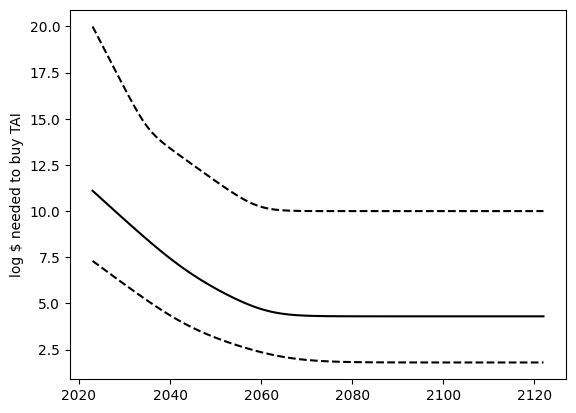

Year: 2023 - 11.1 log 2022$USD to buy TAI (~126 billion) 90% CI 7.3 (~20 million) - 20.0 (~100 quintillion)
Year: 2024 - 10.9 log 2022$USD to buy TAI (~76 billion) 90% CI 7.1 (~13 million) - 19.5 (~33 quintillion)
Year: 2025 - 10.7 log 2022$USD to buy TAI (~45 billion) 90% CI 6.9 (~9 million) - 19.0 (~11 quintillion)
Year: 2026 - 10.4 log 2022$USD to buy TAI (~27 billion) 90% CI 6.8 (~6 million) - 18.6 (~4 quintillion)
Year: 2027 - 10.2 log 2022$USD to buy TAI (~16 billion) 90% CI 6.6 (~4 million) - 18.1 (~1 quintillion)
Year: 2028 - 10.0 log 2022$USD to buy TAI (~10 billion) 90% CI 6.4 (~2 million) - 17.6 (~410 quadrillion)
Year: 2029 - 9.8 log 2022$USD to buy TAI (~6 billion) 90% CI 6.2 (~2 million) - 17.1 (~137 quadrillion)
Year: 2030 - 9.5 log 2022$USD to buy TAI (~3 billion) 90% CI 6.0 (~1 million) - 16.7 (~46 quadrillion)
Year: 2031 - 9.3 log 2022$USD to buy TAI (~2 billion) 90% CI 5.9 (~717 thousand) - 16.2 (~16 quadrillion)
Year: 2032 - 9.1 log 2022$USD to buy TAI (~1 billion) 

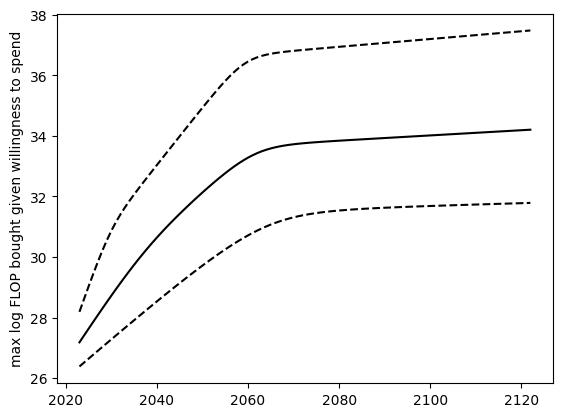

Year: 2023 - max log FLOP 27.2 (~2 octillion) 90% CI 26.4 (~243 septillion) - 28.2 (~15 octillion)
Year: 2024 - max log FLOP 27.4 (~3 octillion) 90% CI 26.5 (~326 septillion) - 28.6 (~41 octillion)
Year: 2025 - max log FLOP 27.6 (~4 octillion) 90% CI 26.6 (~438 septillion) - 29.0 (~106 octillion)
Year: 2026 - max log FLOP 27.9 (~7 octillion) 90% CI 26.8 (~589 septillion) - 29.4 (~270 octillion)
Year: 2027 - max log FLOP 28.1 (~12 octillion) 90% CI 26.9 (~790 septillion) - 29.8 (~669 octillion)
Year: 2028 - max log FLOP 28.3 (~20 octillion) 90% CI 27.0 (~1 octillion) - 30.2 (~2 nonillion)
Year: 2029 - max log FLOP 28.5 (~32 octillion) 90% CI 27.2 (~1 octillion) - 30.5 (~4 nonillion)
Year: 2030 - max log FLOP 28.7 (~53 octillion) 90% CI 27.3 (~2 octillion) - 30.9 (~7 nonillion)
Year: 2031 - max log FLOP 28.9 (~86 octillion) 90% CI 27.4 (~3 octillion) - 31.2 (~14 nonillion)
Year: 2032 - max log FLOP 29.1 (~139 octillion) 90% CI 27.5 (~3 octillion) - 31.4 (~26 nonillion)
Year: 2033 - max l

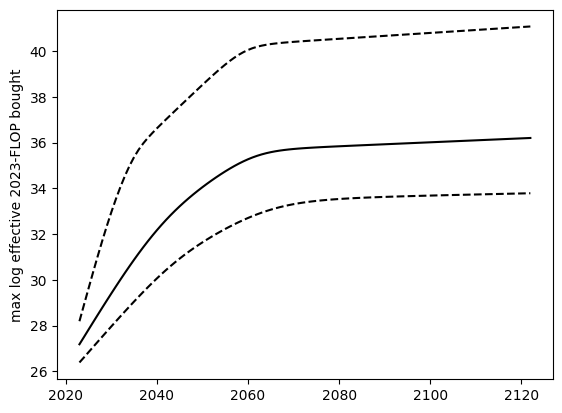

Year: 2023 - max log effective 2023-FLOP 27.2 (~2 octillion) 90% CI 26.4 (~243 septillion) - 28.2 (~15 octillion)
Year: 2024 - max log effective 2023-FLOP 27.5 (~3 octillion) 90% CI 26.6 (~406 septillion) - 28.9 (~81 octillion)
Year: 2025 - max log effective 2023-FLOP 27.8 (~7 octillion) 90% CI 26.8 (~685 septillion) - 29.6 (~423 octillion)
Year: 2026 - max log effective 2023-FLOP 28.1 (~14 octillion) 90% CI 27.1 (~1 octillion) - 30.3 (~2 nonillion)
Year: 2027 - max log effective 2023-FLOP 28.5 (~29 octillion) 90% CI 27.3 (~2 octillion) - 31.0 (~11 nonillion)
Year: 2028 - max log effective 2023-FLOP 28.8 (~60 octillion) 90% CI 27.5 (~3 octillion) - 31.7 (~50 nonillion)
Year: 2029 - max log effective 2023-FLOP 29.1 (~124 octillion) 90% CI 27.7 (~5 octillion) - 32.3 (~222 nonillion)
Year: 2030 - max log effective 2023-FLOP 29.4 (~254 octillion) 90% CI 28.0 (~9 octillion) - 33.0 (~910 nonillion)
Year: 2031 - max log effective 2023-FLOP 29.7 (~514 octillion) 90% CI 28.2 (~15 octillion) - 3

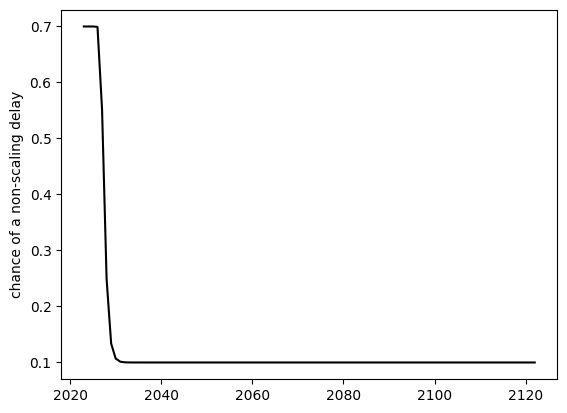

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 55%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033

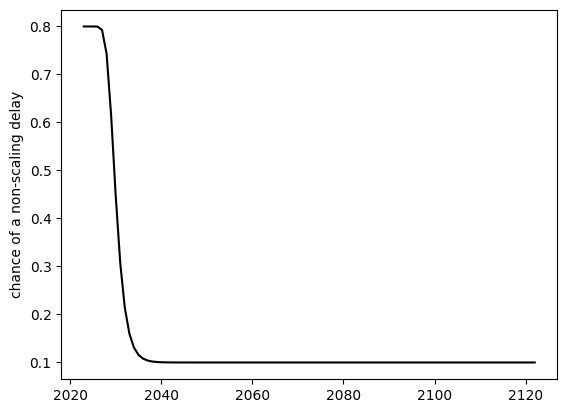

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 79%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 74%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 61%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 45%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 31%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2033

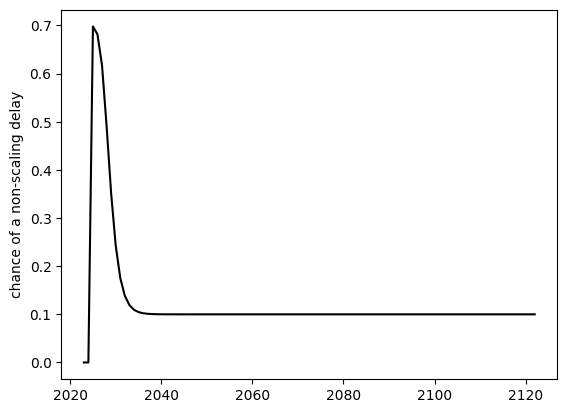

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 68%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 62%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 49%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 35%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2033 -

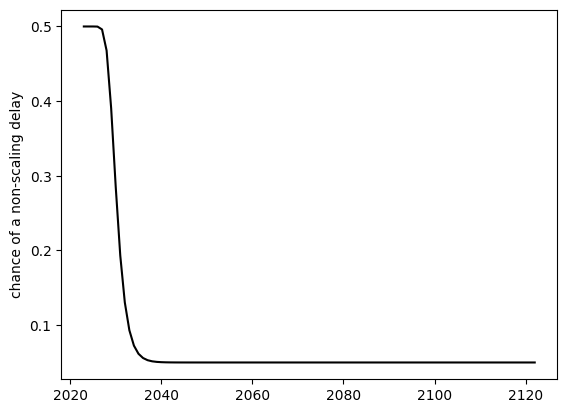

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 47%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 39%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 29%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 19%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2033

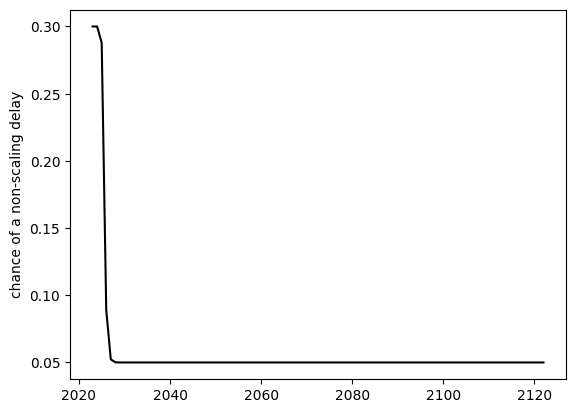

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 29%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 9%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - chan

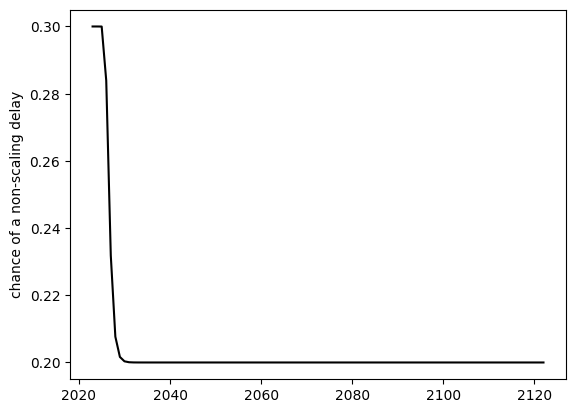

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 28%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 23%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2033

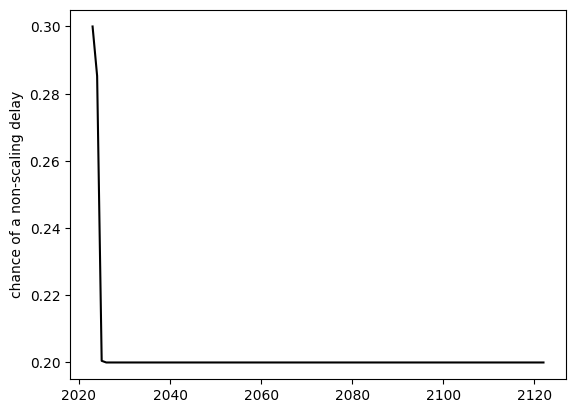

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 29%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2033

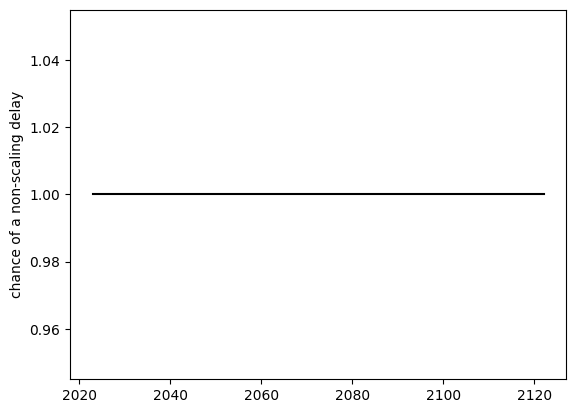

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%


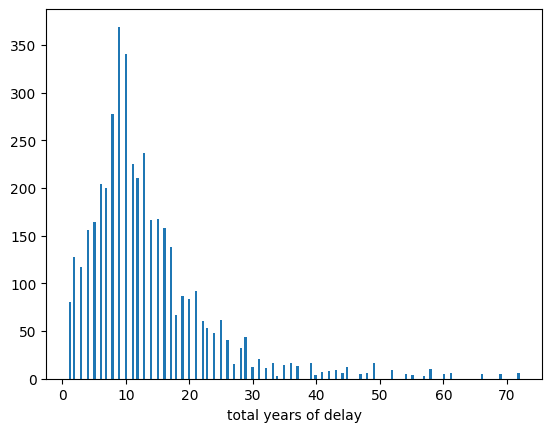

In [9]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    #dump_cache_file='caches/tai_years_metaculus_parity')
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##
It takes 39.5 log FLOP (~3 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.2 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~17 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~495 million). This doubles every 8.1 years to a max of 0.168579% of GDP (initially ~39 billion 2022$USD). GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.9 max log FLOP (795 septillion) available - TAI takes 39.5 log FLOP (3 million decillion) - log $ 21.3 to buy TAI (2 sextillion) vs. willingness to pay log $ 8.7 (489 million) - 18.2 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 39.2 log FLOP (2 million decillion) - log $ 20.9 to buy TAI (746 quintillion) vs. willingness to pay log $ 8.7 (532 million) - 18.

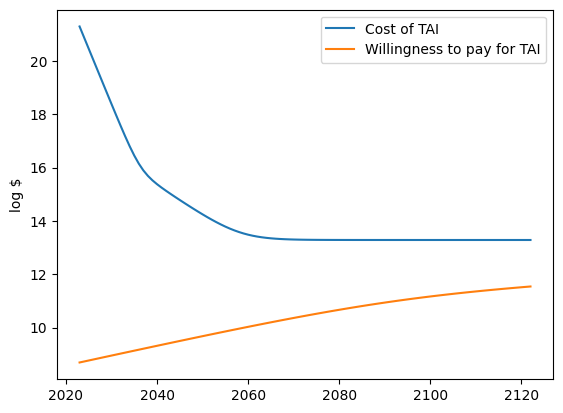

-
-
## SAMPLE RUN 5 ##
It takes 43.1 log FLOP (~13 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.8 log FLOP (~7 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~57 sextillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~941 million). This doubles every 10.2 years to a max of 0.069629% of GDP (initially ~16 billion 2022$USD). GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 27.8 max log FLOP (6 octillion) available - TAI takes 43.1 log FLOP (13 billion decillion) - log $ 24.3 to buy TAI (2 septillion) vs. willingness to pay log $ 8.9 (889 million) - 18.8 log FLOP per $ (7 quintillion) (Effective 2023-logFLOP: 27.8)
Year: 2024 - 27.9 max log FLOP (8 octillion) available - TAI takes 42.8 log FLOP (6 billion decillion) - log $ 23.9 to buy TAI (729 sextillion) vs. willingness to pay log $ 9.0 (949 million) - 18.9

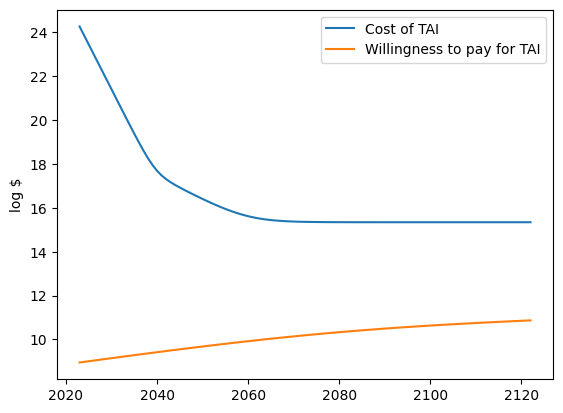

-
-
## SAMPLE RUN 6 ##
It takes 27.9 log FLOP (~8 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~4 septillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~158 million). This doubles every 2.3 years to a max of 0.350133% of GDP (initially ~81 billion 2022$USD). GDP grows at a rate of 1.039x per year.
---
Year: 2023 - 26.8 max log FLOP (694 septillion) available - TAI takes 27.9 log FLOP (8 octillion) - log $ 9.3 to buy TAI (2 billion) vs. willingness to pay log $ 8.2 (158 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 27.8 log FLOP (6 octillion) - log $ 9.0 to buy TAI (1 billion) vs. willingness to pay log $ 8.3 (214 million) - 18.8 log FLOP per $ (6 quintillion) (Ef

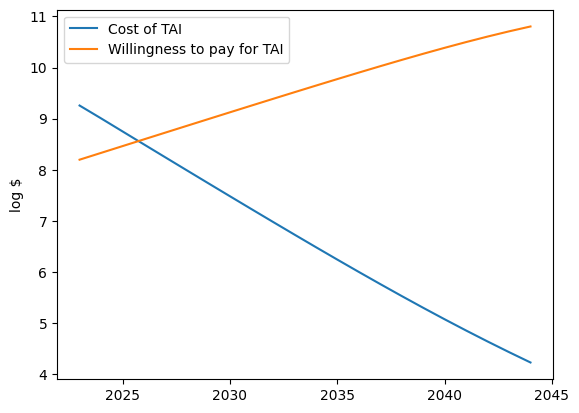

-
-
## SAMPLE RUN 7 ##
It takes 26.2 log FLOP (~158 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.2 log FLOP (~2 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 28.2 log FLOP (~14 octillion) per 2022$USD.
We are initially willing to pay 9.4 log 2022$USD (~2 billion). This doubles every 5.4 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 27.4 max log FLOP (3 octillion) available - TAI takes 26.2 log FLOP (158 septillion) - log $ 8.0 to buy TAI (105 million) vs. willingness to pay log $ 9.2 (2 billion) - 18.2 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.4)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 7

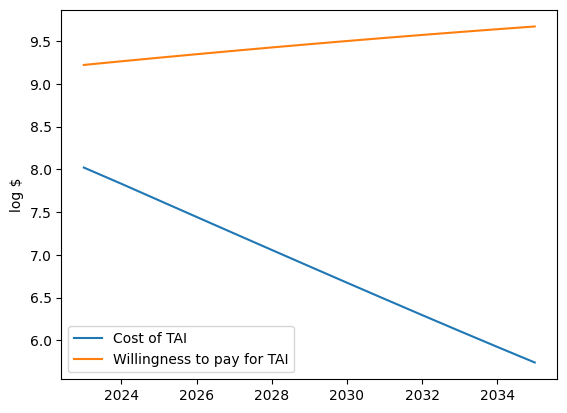

-
-
## SAMPLE RUN 8 ##
It takes 24.2 log FLOP (~2 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.1 log FLOP (~1 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 25.2 log FLOP (~16 septillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~154 million). This doubles every 4.0 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.035x per year.
---
Year: 2023 - 26.2 max log FLOP (178 septillion) available - TAI takes 24.2 log FLOP (2 septillion) - log $ 6.1 to buy TAI (1 million) vs. willingness to pay log $ 8.2 (150 million) - 18.1 log FLOP per $ (1 quintillion) (Effective 2023-logFLOP: 26.2)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay

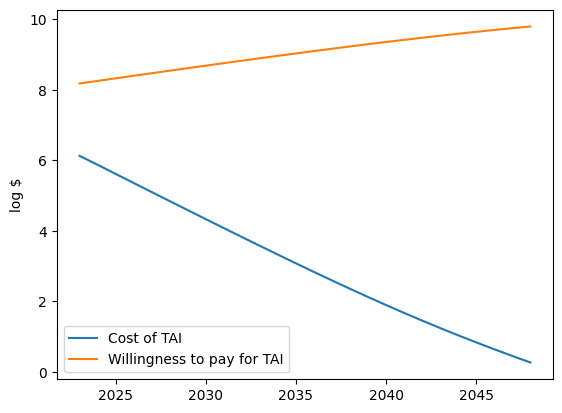

-
-
## SAMPLE RUN 9 ##
It takes 26.6 log FLOP (~398 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~141 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 2.1 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 26.9 max log FLOP (792 septillion) available - TAI takes 26.6 log FLOP (398 septillion) - log $ 8.2 to buy TAI (176 million) vs. willingness to pay log $ 8.5 (350 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 3 years (tota

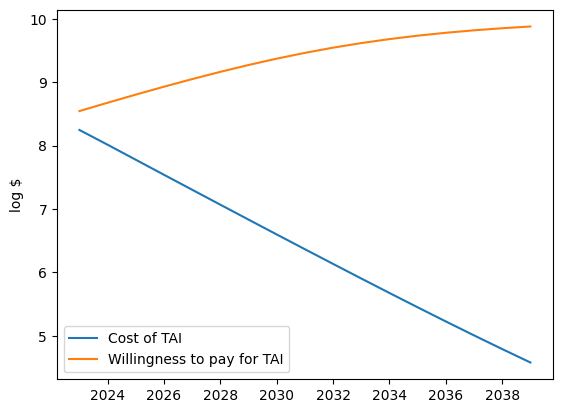

-
-
## SAMPLE RUN 10 ##
It takes 30.6 log FLOP (~4 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~336 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~249 million). This doubles every 1.7 years to a max of 0.151903% of GDP (initially ~35 billion 2022$USD). GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.6 max log FLOP (444 septillion) available - TAI takes 30.6 log FLOP (4 nonillion) - log $ 12.3 to buy TAI (2 trillion) vs. willingness to pay log $ 8.4 (248 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.9 max log FLOP (873 septillion) available - TAI takes 30.5 log FLOP (3 nonillion) - log $ 12.1 to buy TAI (1 trillion) vs. willingness to pay log $ 8.6 (370 million) - 18.4 log FLOP per $ (2 quin

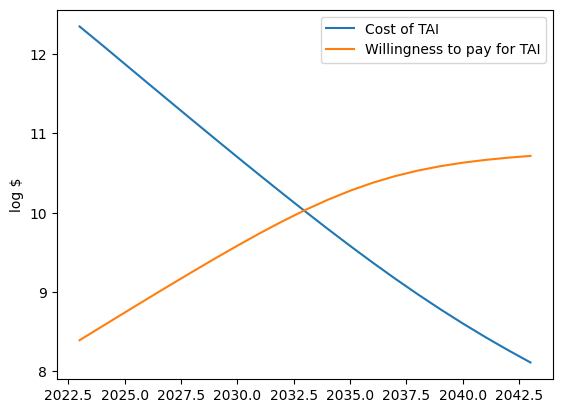

-
-
## SAMPLE RUN 11 ##
It takes 26.7 log FLOP (~501 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 24.8 log FLOP (~6 septillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~305 million). This doubles every 2.9 years to a max of 0.039151% of GDP (initially ~9 billion 2022$USD). GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 27.2 max log FLOP (1 octillion) available - TAI takes 26.7 log FLOP (501 septillion) - log $ 8.0 to buy TAI (99 million) vs. willingness to pay log $ 8.5 (295 million) - 18.7 log FLOP per $ (5 quintillion) (Effective 2023-logFLOP: 27.2)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 8 years (total delay 8 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 32 years (total

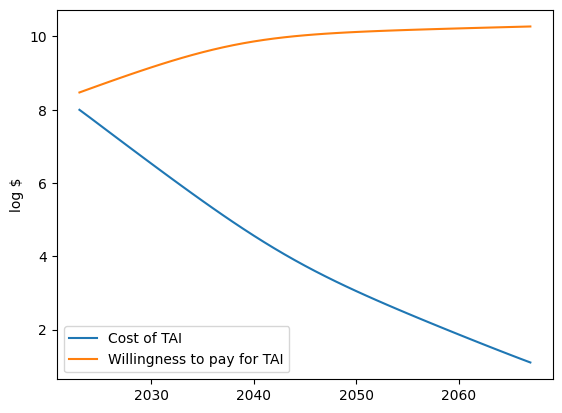

-
-
## SAMPLE RUN 12 ##
It takes 28.8 log FLOP (~63 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 3.5 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~843 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~250 million). This doubles every 4.5 years to a max of 0.232148% of GDP (initially ~53 billion 2022$USD). GDP grows at a rate of 1.008x per year.
---
Year: 2023 - 26.9 max log FLOP (753 septillion) available - TAI takes 28.8 log FLOP (63 octillion) - log $ 10.3 to buy TAI (21 billion) vs. willingness to pay log $ 8.4 (249 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 28.7 log FLOP (51 octillion) - log $ 10.1 to buy TAI (14 billion) vs. willingness to pay log $ 8.5 (291 million) - 18.6 log FLOP per $ (4 quin

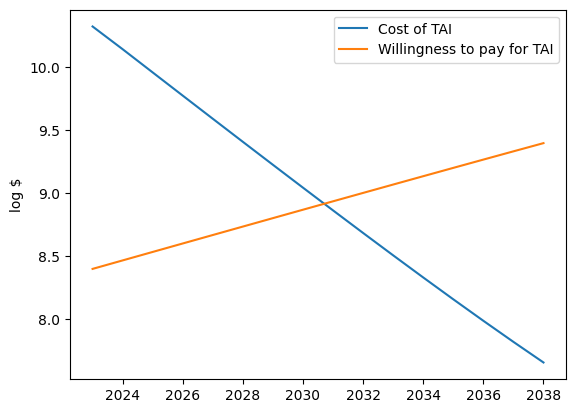

-
-
## SAMPLE RUN 13 ##
It takes 36.7 log FLOP (~5 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 17.9 log FLOP (~804 quadrillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~974 sextillion) per 2022$USD.
We are initially willing to pay 9.3 log 2022$USD (~2 billion). This doubles every 8.2 years to a max of 1.029348% of GDP (initially ~237 billion 2022$USD). GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 36.7 log FLOP (5 thousand decillion) - log $ 18.8 to buy TAI (6 quintillion) vs. willingness to pay log $ 9.3 (2 billion) - 17.9 log FLOP per $ (804 quadrillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.4 max log FLOP (2 octillion) available - TAI takes 36.4 log FLOP (3 thousand decillion) - log $ 18.4 to buy TAI (2 quintillion) vs. willingness to pay log $ 9.3 (2 billion) - 1

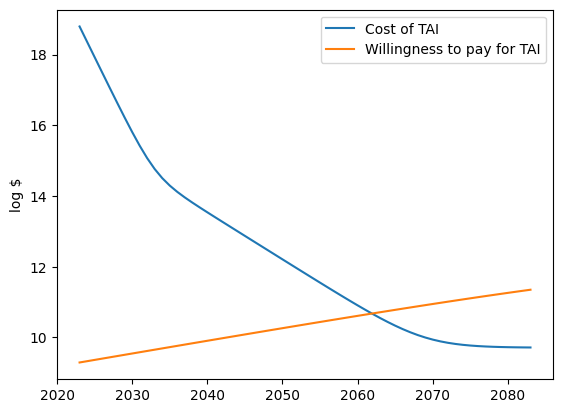

-
-
## SAMPLE RUN 14 ##
It takes 30.3 log FLOP (~2 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~381 sextillion) per 2022$USD.
We are initially willing to pay 9.2 log 2022$USD (~1 billion). This doubles every 2.4 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.013x per year.
---
Year: 2023 - 27.7 max log FLOP (5 octillion) available - TAI takes 30.3 log FLOP (2 nonillion) - log $ 11.7 to buy TAI (501 billion) vs. willingness to pay log $ 9.1 (1 billion) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 27.7)
Year: 2024 - 27.9 max log FLOP (7 octillion) available - TAI takes 30.2 log FLOP (2 nonillion) - log $ 11.5 to buy TAI (304 billion) vs. willingness to pay log $ 9.2 (1 billion) - 18.7 log FLOP per $ (5 quintillion) (Effe

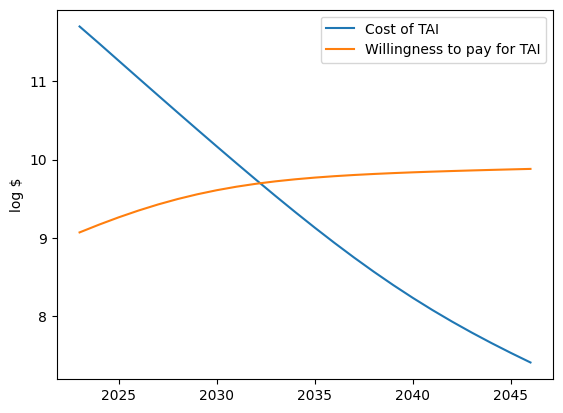

-
-
## SAMPLE RUN 15 ##
It takes 42.0 log FLOP (~1 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.5 log FLOP (~3 septillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 3.2 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 26.9 max log FLOP (880 septillion) available - TAI takes 42.0 log FLOP (1 billion decillion) - log $ 23.4 to buy TAI (262 sextillion) vs. willingness to pay log $ 8.4 (231 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 41.7 log FLOP (500 million decillion) - log $ 23.0 to buy TAI (102 sextillion) vs. willingness to pay log $ 8.5 (285 million) - 18.7

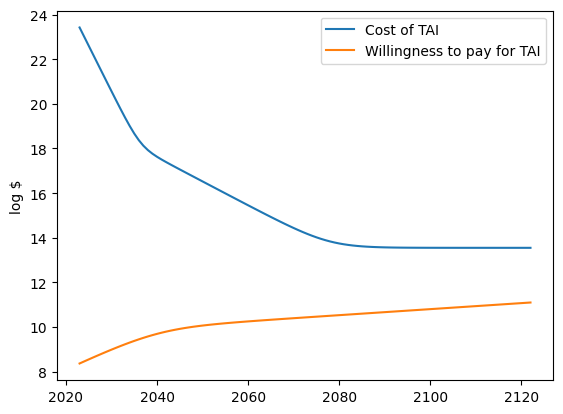

-
-
## SAMPLE RUN 16 ##
It takes 33.2 log FLOP (~2 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~49 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~755 million). This doubles every 3.4 years to a max of 0.066097% of GDP (initially ~15 billion 2022$USD). GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 33.2 log FLOP (2 decillion) - log $ 14.6 to buy TAI (392 trillion) vs. willingness to pay log $ 8.9 (719 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 27.5)
Year: 2024 - 27.7 max log FLOP (4 octillion) available - TAI takes 33.1 log FLOP (1 decillion) - log $ 14.3 to buy TAI (222 trillion) vs. willingness to pay log $ 8.9 (875 million) - 18.7 log FLOP per $ (5 quintil

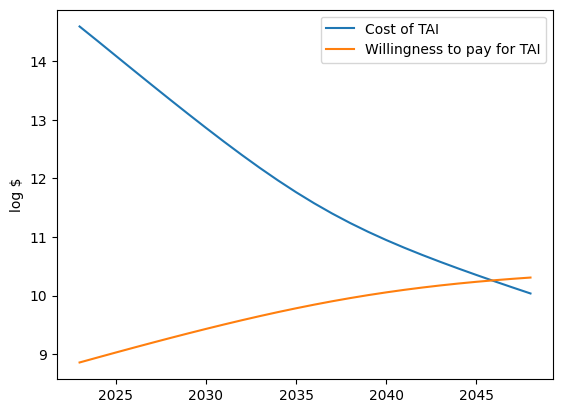

-
-
## SAMPLE RUN 17 ##
It takes 30.6 log FLOP (~4 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.0 log FLOP (~11 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 9.2 log 2022$USD (~1 billion). This doubles every 3.6 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 28.1 max log FLOP (13 octillion) available - TAI takes 30.6 log FLOP (4 nonillion) - log $ 11.6 to buy TAI (367 billion) vs. willingness to pay log $ 9.1 (1 billion) - 19.0 log FLOP per $ (11 quintillion) (Effective 2023-logFLOP: 28.1)
Year: 2024 - 28.3 max log FLOP (19 octillion) available - TAI takes 30.5 log FLOP (3 nonillion) - log $ 11.3 to buy TAI (221 billion) vs. willingness to pay log $ 9.1 (1 billion) - 19.1 log FLOP per $ (14 quintillion) (E

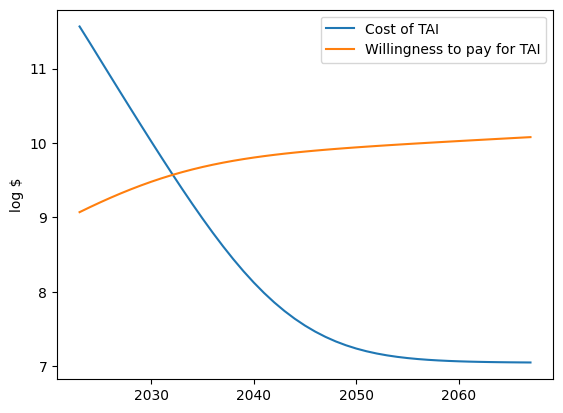

-
-
## SAMPLE RUN 18 ##
It takes 27.3 log FLOP (~2 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.0 log FLOP (~936 quadrillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1 septillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~480 million). This doubles every 9.3 years to a max of 0.048343% of GDP (initially ~11 billion 2022$USD). GDP grows at a rate of 1.008x per year.
---
Year: 2023 - 26.6 max log FLOP (430 septillion) available - TAI takes 27.3 log FLOP (2 octillion) - log $ 9.3 to buy TAI (2 billion) vs. willingness to pay log $ 8.7 (460 million) - 18.0 log FLOP per $ (936 quadrillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (578 septillion) available - TAI takes 27.2 log FLOP (2 octillion) - log $ 9.1 to buy TAI (1 billion) vs. willingness to pay log $ 8.7 (494 million) - 18.1 log FLOP per $ (1 quintill

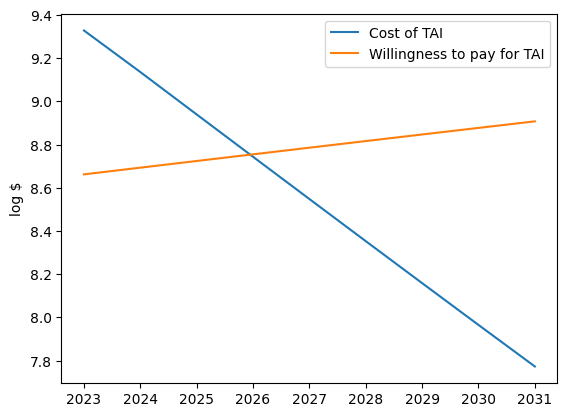

-
-
## SAMPLE RUN 19 ##
It takes 27.1 log FLOP (~1 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.4 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~569 million). This doubles every 3.1 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.037x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 27.1 log FLOP (1 octillion) - log $ 8.7 to buy TAI (526 million) vs. willingness to pay log $ 8.7 (517 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 27.0 log FLOP (1 octillion) - log $ 8.5 to buy TAI (324 million) vs. willingness to pay log $ 8.8 (635 million) - 18.5 log FLOP per $ (3 quintillion) (Effe

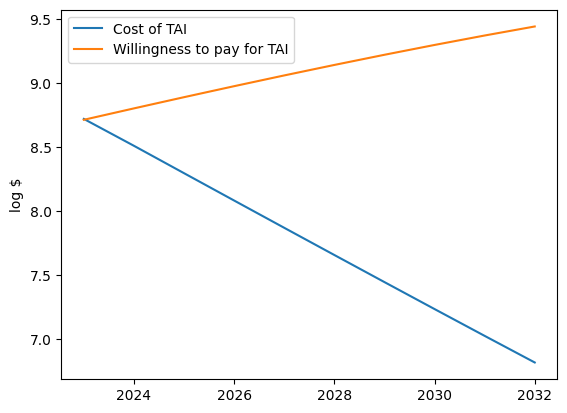

-
-
## SAMPLE RUN 20 ##
It takes 43.4 log FLOP (~25 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.0 log FLOP (~1 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~3 septillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~198 million). This doubles every 7.5 years to a max of 0.130014% of GDP (initially ~30 billion 2022$USD). GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 26.3 max log FLOP (202 septillion) available - TAI takes 43.4 log FLOP (25 billion decillion) - log $ 25.4 to buy TAI (25 septillion) vs. willingness to pay log $ 8.3 (197 million) - 18.0 log FLOP per $ (1 quintillion) (Effective 2023-logFLOP: 26.3)
Year: 2024 - 26.5 max log FLOP (306 septillion) available - TAI takes 43.1 log FLOP (13 billion decillion) - log $ 24.9 to buy TAI (9 septillion) vs. willingness to pay log $ 8.3 (216 million) -

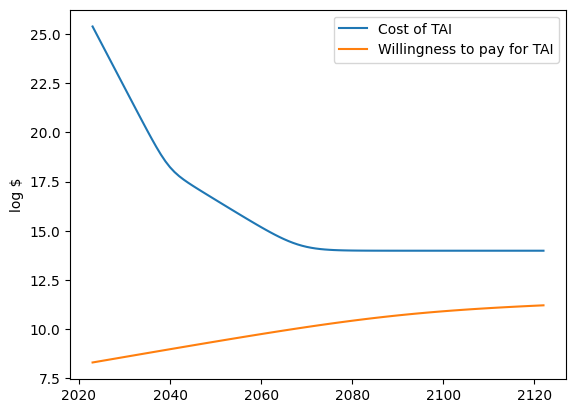

-
-
## SAMPLE RUN 21 ##
It takes 26.1 log FLOP (~126 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~2 quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~388 million). This doubles every 4.8 years to a max of 0.068779% of GDP (initially ~16 billion 2022$USD). GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 26.9 max log FLOP (885 septillion) available - TAI takes 26.1 log FLOP (126 septillion) - log $ 7.7 to buy TAI (54 million) vs. willingness to pay log $ 8.6 (379 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 10 years (total delay 10 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 8 years (

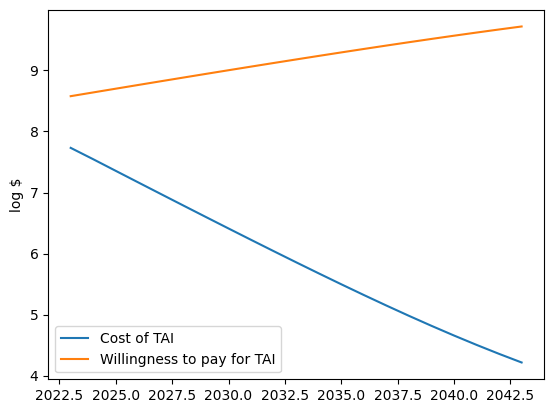

-
-
## SAMPLE RUN 22 ##
It takes 39.3 log FLOP (~2 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 1.3 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~730 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~461 million). This doubles every 1.0 years until 2025, and then doubles every 0.9 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 39.3 log FLOP (2 million decillion) - log $ 20.7 to buy TAI (465 quintillion) vs. willingness to pay log $ 8.6 (427 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 27.3)
Year: 2024 - 27.8 max log FLOP (6 octillion) available - TAI takes 39.0 log FLOP (998 thousand decillion) - log $ 20.1 to buy TAI (139 quintillion) vs. wi

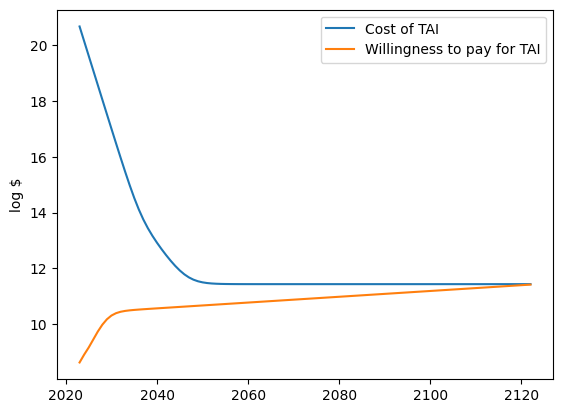

-
-
## SAMPLE RUN 23 ##
It takes 28.3 log FLOP (~20 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.2 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~873 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~306 million). This doubles every 3.8 years to a max of 0.039607% of GDP (initially ~9 billion 2022$USD). GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 26.7 max log FLOP (514 septillion) available - TAI takes 28.3 log FLOP (20 octillion) - log $ 10.1 to buy TAI (11 billion) vs. willingness to pay log $ 8.5 (296 million) - 18.2 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 26.9 max log FLOP (869 septillion) available - TAI takes 28.2 log FLOP (16 octillion) - log $ 9.8 to buy TAI (7 billion) vs. willingness to pay log $ 8.5 (353 million) - 18.4 log FLOP per $ (2 quint

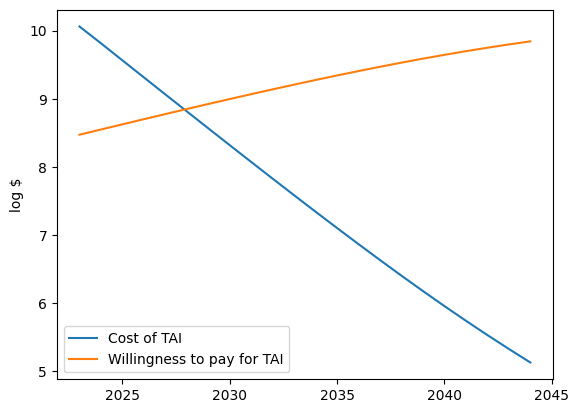

-
-
## SAMPLE RUN 24 ##
It takes 26.2 log FLOP (~158 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 1.0 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~7 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~608 million). This doubles every 6.7 years to a max of 0.072786% of GDP (initially ~17 billion 2022$USD). GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 26.2 log FLOP (158 septillion) - log $ 7.6 to buy TAI (42 million) vs. willingness to pay log $ 8.8 (587 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 27.3)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 4 years (total

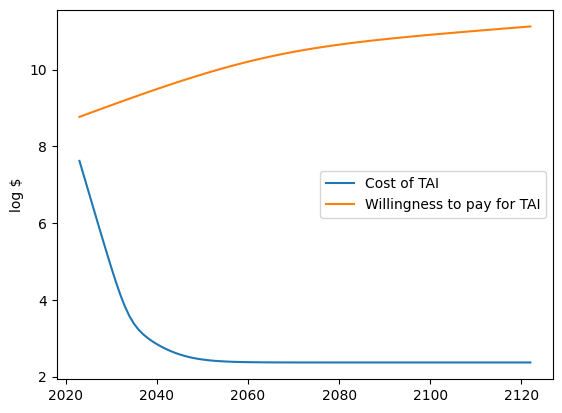

-
-
## SAMPLE RUN 25 ##
It takes 26.4 log FLOP (~251 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 1.5 years they get 2x cheaper, to a maximum of 21.0 log FLOP (~1 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 3.5 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 27.0 max log FLOP (894 septillion) available - TAI takes 26.4 log FLOP (251 septillion) - log $ 7.8 to buy TAI (65 million) vs. willingness to pay log $ 8.4 (231 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 27.0)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0

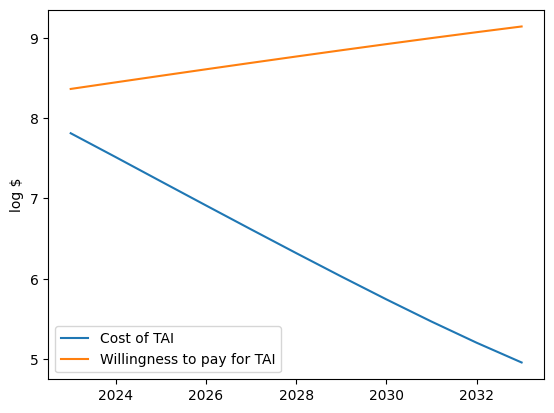

-
-
## SAMPLE RUN 26 ##
It takes 29.0 log FLOP (~100 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 3.5 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~3 septillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~195 million). This doubles every 5.2 years to a max of 0.035302% of GDP (initially ~8 billion 2022$USD). GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 26.8 max log FLOP (580 septillion) available - TAI takes 29.0 log FLOP (100 octillion) - log $ 10.5 to buy TAI (33 billion) vs. willingness to pay log $ 8.3 (190 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 26.9 max log FLOP (807 septillion) available - TAI takes 28.9 log FLOP (80 octillion) - log $ 10.3 to buy TAI (22 billion) vs. willingness to pay log $ 8.3 (217 million) - 18.6 log FLOP per $ (4 qu

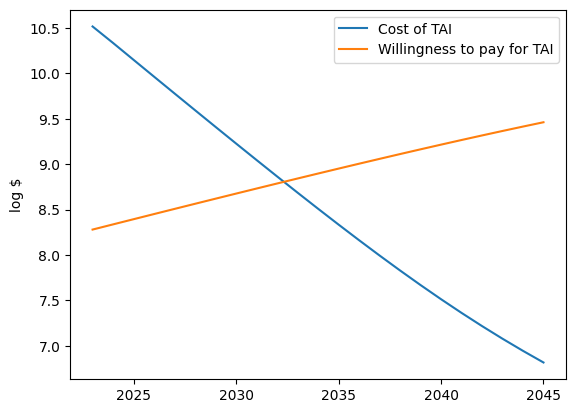

-
-
## SAMPLE RUN 27 ##
It takes 28.1 log FLOP (~13 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 25.5 log FLOP (~33 septillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~852 million). This doubles every 4.2 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 27.6 max log FLOP (4 octillion) available - TAI takes 28.1 log FLOP (13 octillion) - log $ 9.4 to buy TAI (2 billion) vs. willingness to pay log $ 8.9 (742 million) - 18.7 log FLOP per $ (5 quintillion) (Effective 2023-logFLOP: 27.6)
Year: 2024 - 27.8 max log FLOP (6 octillion) available - TAI takes 28.0 log FLOP (10 octillion) - log $ 9.2 to buy TAI (2 billion) vs. willingness to pay log $ 8.9 (857 million) - 18.8 log FLOP per $ (7 quintillion) (Ef

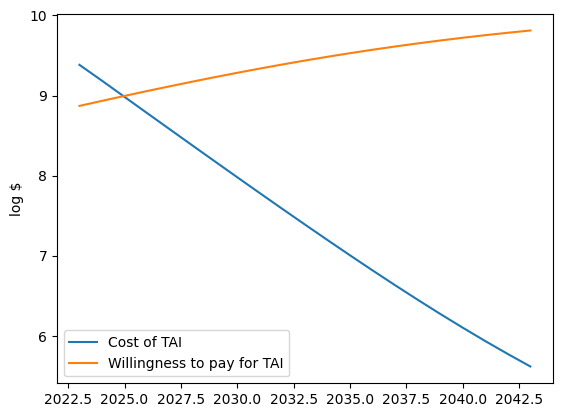

-
-
## SAMPLE RUN 28 ##
It takes 27.0 log FLOP (~1 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 17.8 log FLOP (~697 quadrillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 26.2 log FLOP (~155 septillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 8.6 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 26.4 max log FLOP (244 septillion) available - TAI takes 27.0 log FLOP (1 octillion) - log $ 9.2 to buy TAI (1 billion) vs. willingness to pay log $ 8.5 (350 million) - 17.8 log FLOP per $ (697 quadrillion) (Effective 2023-logFLOP: 26.4)
Year: 2024 - 26.6 max log FLOP (378 septillion) available - TAI takes 26.9 log FLOP (804 septillion) - log $ 8.9 to buy TAI (802 million) vs. willingness to pay log $ 8.6 (378 million) - 18.0 log FLOP per $ (1 quint

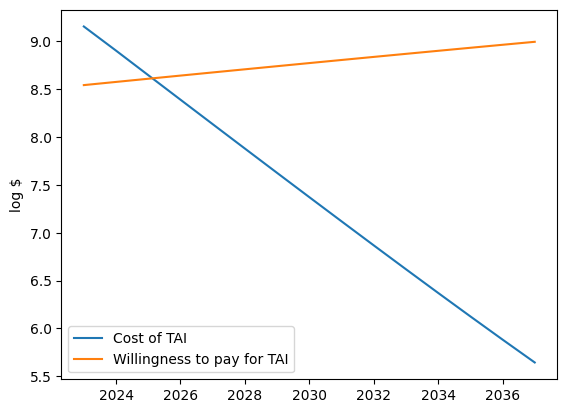

-
-
## SAMPLE RUN 29 ##
It takes 35.4 log FLOP (~251 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.2 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 25.0 log FLOP (~10 septillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~746 million). This doubles every 6.6 years to a max of 0.052984% of GDP (initially ~12 billion 2022$USD). GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 35.4 log FLOP (251 decillion) - log $ 17.2 to buy TAI (143 quadrillion) vs. willingness to pay log $ 8.8 (703 million) - 18.2 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 35.2 log FLOP (158 decillion) - log $ 16.8 to buy TAI (69 quadrillion) vs. willingness to pay log $ 8.9 (776 million) - 18.4 log FLOP per $

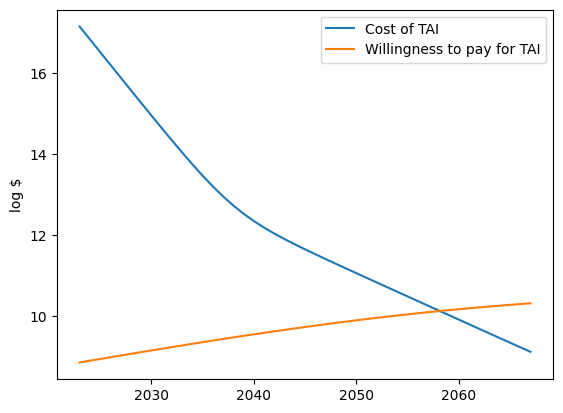

-
-
## SAMPLE RUN 30 ##
It takes 41.0 log FLOP (~100 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.1 log FLOP (~1 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~12 sextillion) per 2022$USD.
We are initially willing to pay 9.1 log 2022$USD (~1 billion). This doubles every 3.5 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.005x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 41.0 log FLOP (100 million decillion) - log $ 22.9 to buy TAI (75 sextillion) vs. willingness to pay log $ 9.0 (1 billion) - 18.1 log FLOP per $ (1 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.4 max log FLOP (2 octillion) available - TAI takes 40.7 log FLOP (50 million decillion) - log $ 22.4 to buy TAI (26 sextillion) vs. willingness to pay log $ 9.1 (1 billion) - 18.3 log FL

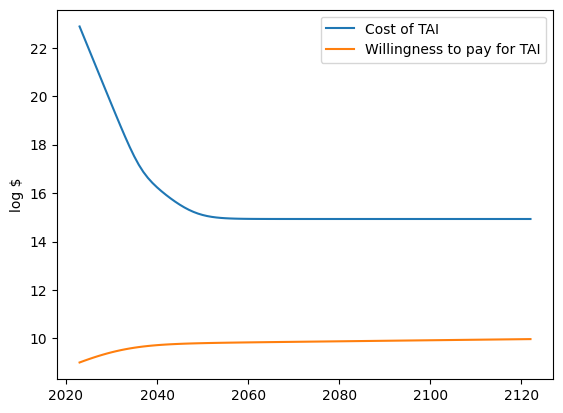

-
-
## SAMPLE RUN 31 ##
It takes 30.8 log FLOP (~6 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.1 log FLOP (~12 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~6 septillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~391 million). This doubles every 5.6 years to a max of 0.097145% of GDP (initially ~22 billion 2022$USD). GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 27.7 max log FLOP (5 octillion) available - TAI takes 30.8 log FLOP (6 nonillion) - log $ 11.7 to buy TAI (534 billion) vs. willingness to pay log $ 8.6 (384 million) - 19.1 log FLOP per $ (12 quintillion) (Effective 2023-logFLOP: 27.7)
Year: 2024 - 27.8 max log FLOP (7 octillion) available - TAI takes 30.7 log FLOP (5 nonillion) - log $ 11.5 to buy TAI (311 billion) vs. willingness to pay log $ 8.6 (434 million) - 19.2 log FLOP per $ (16 quintil

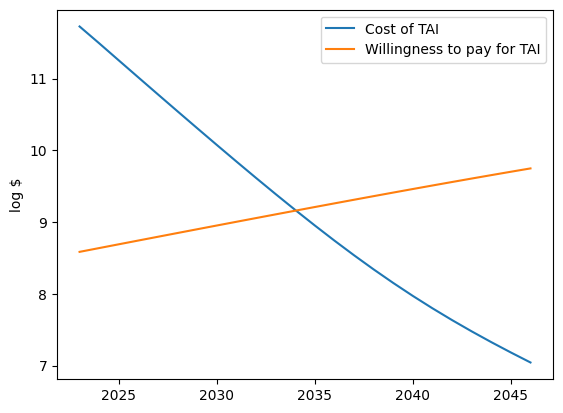

-
-
## SAMPLE RUN 32 ##
It takes 25.5 log FLOP (~32 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.9 log FLOP (~8 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~3 septillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~464 million). This doubles every 2.7 years to a max of 0.027201% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 25.5 log FLOP (32 septillion) - log $ 6.6 to buy TAI (4 million) vs. willingness to pay log $ 8.6 (432 million) - 18.9 log FLOP per $ (8 quintillion) (Effective 2023-logFLOP: 27.5)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 7 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 9 years (total del

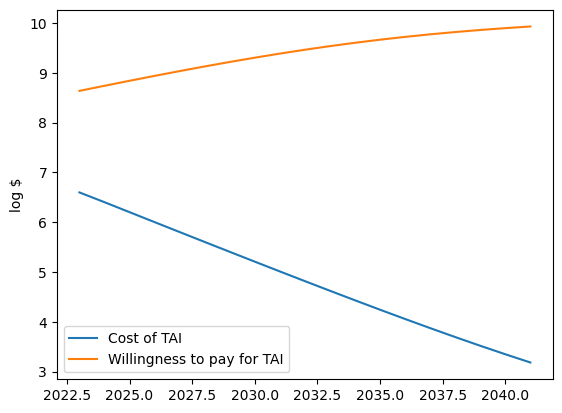

-
-
## SAMPLE RUN 33 ##
It takes 38.1 log FLOP (~126 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~3 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 25.1 log FLOP (~13 septillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~198 million). This doubles every 5.2 years to a max of 0.161108% of GDP (initially ~37 billion 2022$USD). GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 26.7 max log FLOP (512 septillion) available - TAI takes 38.1 log FLOP (126 thousand decillion) - log $ 19.7 to buy TAI (48 quintillion) vs. willingness to pay log $ 8.3 (197 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 26.9 max log FLOP (750 septillion) available - TAI takes 37.8 log FLOP (63 thousand decillion) - log $ 19.3 to buy TAI (19 quintillion) vs. willingness to pay log $ 8.4 (226 mi

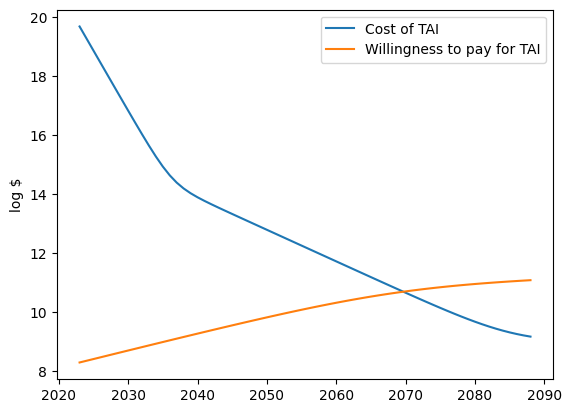

-
-
## SAMPLE RUN 34 ##
It takes 35.8 log FLOP (~631 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 1.5 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~829 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~492 million). This doubles every 1.0 years until 2025, and then doubles every 0.9 years to a max of 0.119118% of GDP (initially ~27 billion 2022$USD). GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 35.8 log FLOP (631 decillion) - log $ 17.2 to buy TAI (148 quadrillion) vs. willingness to pay log $ 8.7 (483 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 27.3)
Year: 2024 - 27.8 max log FLOP (7 octillion) available - TAI takes 35.6 log FLOP (398 decillion) - log $ 16.8 to buy TAI (59 quadrillion) vs. willingness to pay

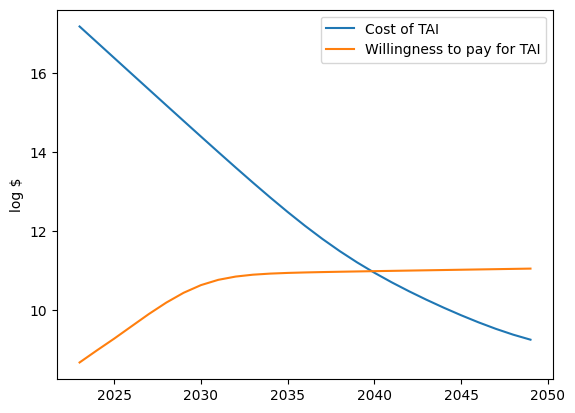

-
-
## SAMPLE RUN 35 ##
It takes 29.9 log FLOP (~794 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.0 log FLOP (~10 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~404 sextillion) per 2022$USD.
We are initially willing to pay 9.2 log 2022$USD (~2 billion). This doubles every 1.3 years to a max of 0.034519% of GDP (initially ~8 billion 2022$USD). GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 28.1 max log FLOP (13 octillion) available - TAI takes 29.9 log FLOP (794 octillion) - log $ 10.9 to buy TAI (80 billion) vs. willingness to pay log $ 9.1 (1 billion) - 19.0 log FLOP per $ (10 quintillion) (Effective 2023-logFLOP: 28.1)
Year: 2024 - 28.4 max log FLOP (27 octillion) available - TAI takes 29.8 log FLOP (638 octillion) - log $ 10.7 to buy TAI (47 billion) vs. willingness to pay log $ 9.3 (2 billion) - 19.1 log FLOP per $ (13 quinti

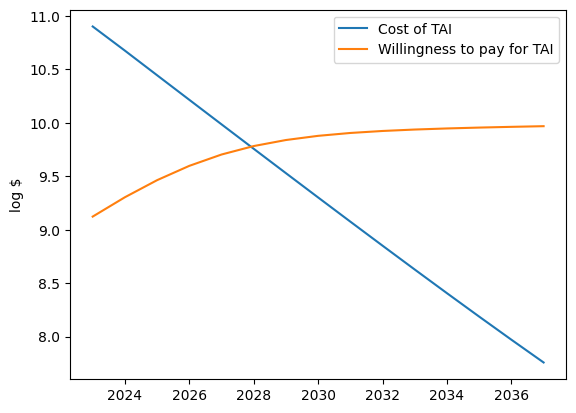

-
-
## SAMPLE RUN 36 ##
It takes 29.1 log FLOP (~126 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~698 million). This doubles every 6.1 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 29.1 log FLOP (126 octillion) - log $ 10.8 to buy TAI (63 billion) vs. willingness to pay log $ 8.8 (622 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 29.0 log FLOP (101 octillion) - log $ 10.6 to buy TAI (40 billion) vs. willingness to pay log $ 8.8 (690 million) - 18.4 log FLOP per $ (3 quintillio

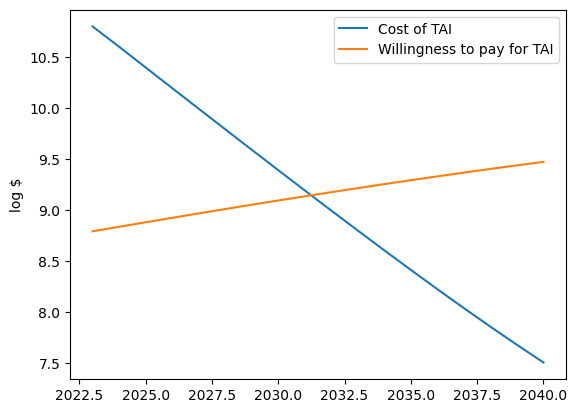

-
-
## SAMPLE RUN 37 ##
It takes 26.9 log FLOP (~794 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.8 log FLOP (~7 quintillion) per 2022$USD. Every 1.8 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~417 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 2.8 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.036x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 26.9 log FLOP (794 septillion) - log $ 8.1 to buy TAI (121 million) vs. willingness to pay log $ 8.4 (231 million) - 18.8 log FLOP per $ (7 quintillion) (Effective 2023-logFLOP: 27.2)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 8 years (total delay 8 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=

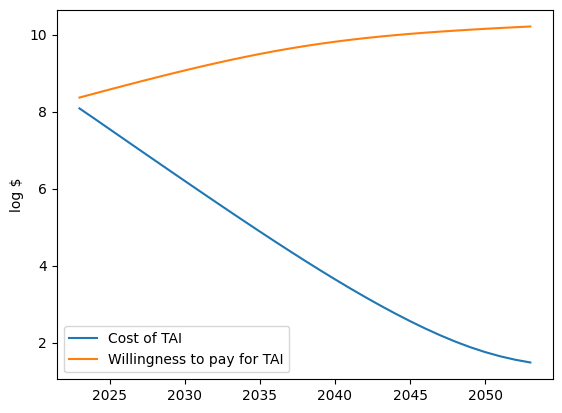

-
-
## SAMPLE RUN 38 ##
It takes 27.3 log FLOP (~2 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 4.0 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~288 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~467 million). This doubles every 4.8 years to a max of 0.029399% of GDP (initially ~7 billion 2022$USD). GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 27.0 max log FLOP (953 septillion) available - TAI takes 27.3 log FLOP (2 octillion) - log $ 9.0 to buy TAI (914 million) vs. willingness to pay log $ 8.6 (436 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 27.2 log FLOP (2 octillion) - log $ 8.8 to buy TAI (616 million) vs. willingness to pay log $ 8.7 (501 million) - 18.4 log FLOP per $ (3 quintillion

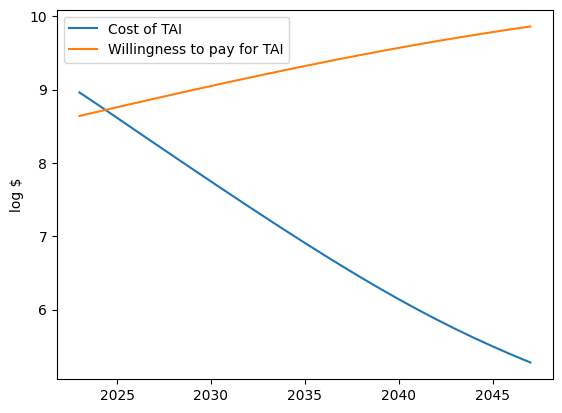

-
-
## SAMPLE RUN 39 ##
It takes 28.6 log FLOP (~40 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 17.8 log FLOP (~626 quadrillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~395 million). This doubles every 9.9 years to a max of 0.215267% of GDP (initially ~50 billion 2022$USD). GDP grows at a rate of 1.011x per year.
---
Year: 2023 - 26.4 max log FLOP (245 septillion) available - TAI takes 28.6 log FLOP (40 octillion) - log $ 10.8 to buy TAI (64 billion) vs. willingness to pay log $ 8.6 (392 million) - 17.8 log FLOP per $ (626 quadrillion) (Effective 2023-logFLOP: 26.4)
Year: 2024 - 26.5 max log FLOP (334 septillion) available - TAI takes 28.5 log FLOP (32 octillion) - log $ 10.6 to buy TAI (40 billion) vs. willingness to pay log $ 8.6 (420 million) - 17.9 log FLOP per $ (7

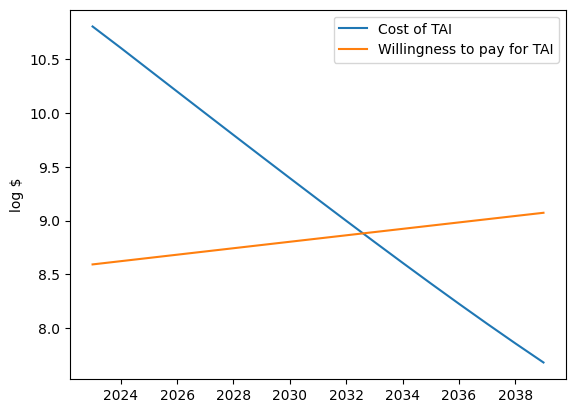

-
-
## SAMPLE RUN 40 ##
It takes 26.0 log FLOP (~100 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.1 log FLOP (~11 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~74 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~737 million). This doubles every 2.5 years to a max of 0.044534% of GDP (initially ~10 billion 2022$USD). GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 27.9 max log FLOP (8 octillion) available - TAI takes 26.0 log FLOP (100 septillion) - log $ 6.9 to buy TAI (9 million) vs. willingness to pay log $ 8.8 (688 million) - 19.1 log FLOP per $ (11 quintillion) (Effective 2023-logFLOP: 27.9)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 7 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 1 years (tota

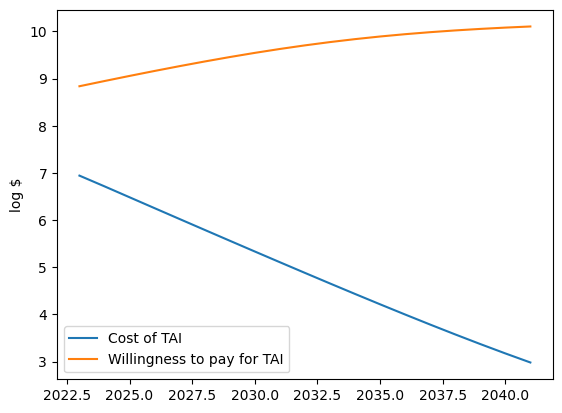

-
-
## SAMPLE RUN 41 ##
It takes 38.8 log FLOP (~631 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.9 log FLOP (~7 quintillion) per 2022$USD. Every 3.7 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~569 million). This doubles every 6.4 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 27.6 max log FLOP (4 octillion) available - TAI takes 38.8 log FLOP (631 thousand decillion) - log $ 19.9 to buy TAI (85 quintillion) vs. willingness to pay log $ 8.7 (517 million) - 18.9 log FLOP per $ (7 quintillion) (Effective 2023-logFLOP: 27.6)
Year: 2024 - 27.7 max log FLOP (5 octillion) available - TAI takes 38.5 log FLOP (316 thousand decillion) - log $ 19.5 to buy TAI (35 quintillion) vs. willingness to pay log $ 8.8 (572 million) - 1

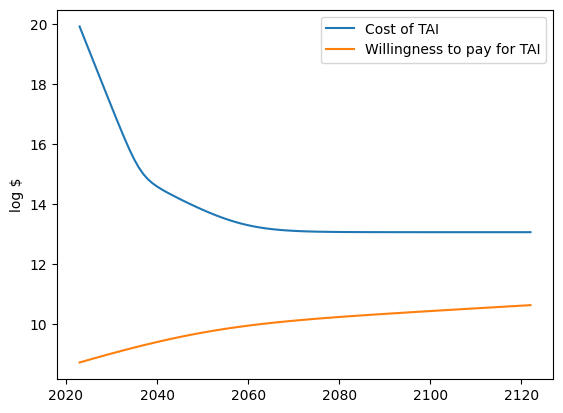

-
-
## SAMPLE RUN 42 ##
It takes 26.2 log FLOP (~158 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~3 quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 9.1 log 2022$USD (~1 billion). This doubles every 2.5 years to a max of 0.076002% of GDP (initially ~17 billion 2022$USD). GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 27.4 max log FLOP (3 octillion) available - TAI takes 26.2 log FLOP (158 septillion) - log $ 7.8 to buy TAI (63 million) vs. willingness to pay log $ 9.0 (1 billion) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.4)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.0

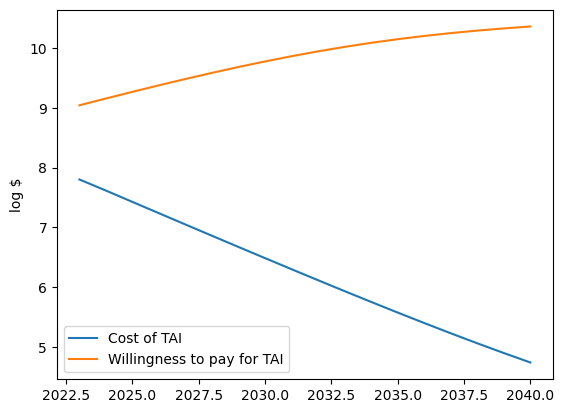

-
-
## SAMPLE RUN 43 ##
It takes 34.6 log FLOP (~40 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 19.0 log FLOP (~10 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~604 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~308 million). This doubles every 2.3 years to a max of 0.052003% of GDP (initially ~12 billion 2022$USD). GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 34.6 log FLOP (40 decillion) - log $ 15.6 to buy TAI (4 quadrillion) vs. willingness to pay log $ 8.5 (300 million) - 19.0 log FLOP per $ (10 quintillion) (Effective 2023-logFLOP: 27.5)
Year: 2024 - 27.7 max log FLOP (5 octillion) available - TAI takes 34.4 log FLOP (25 decillion) - log $ 15.3 to buy TAI (2 quadrillion) vs. willingness to pay log $ 8.6 (403 million) - 19.1 log FLOP per $ (1

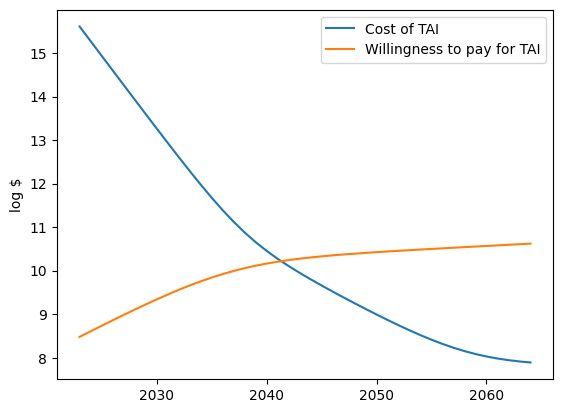

-
-
## SAMPLE RUN 44 ##
It takes 27.1 log FLOP (~1 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.8 log FLOP (~6 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~108 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~624 million). This doubles every 10.5 years to a max of 0.236275% of GDP (initially ~54 billion 2022$USD). GDP grows at a rate of 1.01x per year.
---
Year: 2023 - 27.6 max log FLOP (4 octillion) available - TAI takes 27.1 log FLOP (1 octillion) - log $ 8.3 to buy TAI (194 million) vs. willingness to pay log $ 8.8 (617 million) - 18.8 log FLOP per $ (6 quintillion) (Effective 2023-logFLOP: 27.6)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (total de

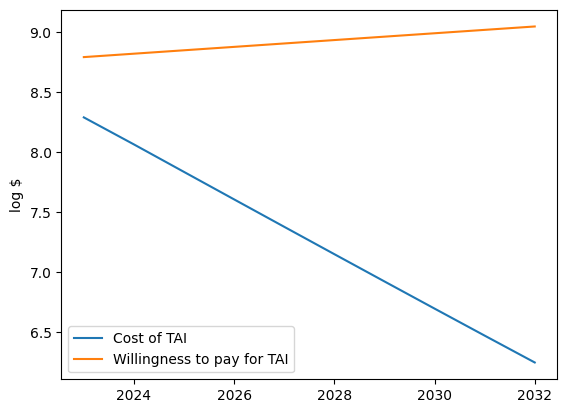

-
-
## SAMPLE RUN 45 ##
It takes 32.4 log FLOP (~251 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 1.8 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~154 million). This doubles every 4.0 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.8 max log FLOP (593 septillion) available - TAI takes 32.4 log FLOP (251 nonillion) - log $ 13.8 to buy TAI (64 trillion) vs. willingness to pay log $ 8.2 (150 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 32.3 log FLOP (180 nonillion) - log $ 13.5 to buy TAI (31 trillion) vs. willingness to pay log $ 8.3 (178 million) - 18.8 log FLOP per $ (6 quint

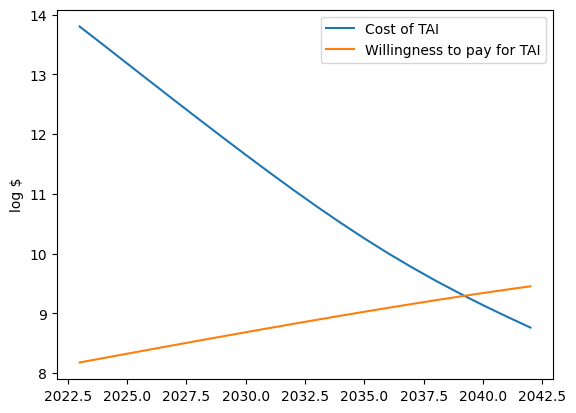

-
-
## SAMPLE RUN 46 ##
It takes 24.1 log FLOP (~1 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~62 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 1.2 years to a max of 0.025053% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.049x per year.
---
Year: 2023 - 27.0 max log FLOP (1 octillion) available - TAI takes 24.1 log FLOP (1 septillion) - log $ 5.4 to buy TAI (261 thousand) vs. willingness to pay log $ 8.4 (231 million) - 18.7 log FLOP per $ (5 quintillion) (Effective 2023-logFLOP: 27.0)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0

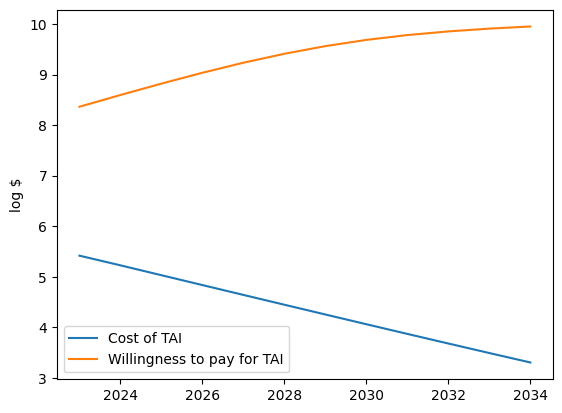

-
-
## SAMPLE RUN 47 ##
It takes 32.6 log FLOP (~398 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.8 log FLOP (~7 quintillion) per 2022$USD. Every 3.5 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~15 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~486 million). This doubles every 12.1 years to a max of 0.070441% of GDP (initially ~16 billion 2022$USD). GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 32.6 log FLOP (398 nonillion) - log $ 13.8 to buy TAI (58 trillion) vs. willingness to pay log $ 8.7 (472 million) - 18.8 log FLOP per $ (7 quintillion) (Effective 2023-logFLOP: 27.5)
Year: 2024 - 27.6 max log FLOP (4 octillion) available - TAI takes 32.5 log FLOP (285 nonillion) - log $ 13.5 to buy TAI (34 trillion) vs. willingness to pay log $ 8.7 (499 million) - 18.9 log FLOP per $ (8 qui

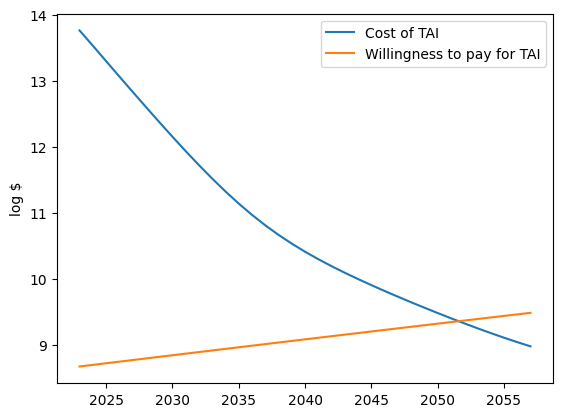

-
-
## SAMPLE RUN 48 ##
It takes 24.7 log FLOP (~5 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.9 log FLOP (~7 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 20.1 log FLOP (~134 quintillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~374 million). This doubles every 3.3 years to a max of 0.026853% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.011x per year.
---
Year: 2023 - 27.4 max log FLOP (2 octillion) available - TAI takes 24.7 log FLOP (5 septillion) - log $ 5.9 to buy TAI (734 thousand) vs. willingness to pay log $ 8.5 (353 million) - 18.8 log FLOP per $ (7 quintillion) (Effective 2023-logFLOP: 27.4)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p

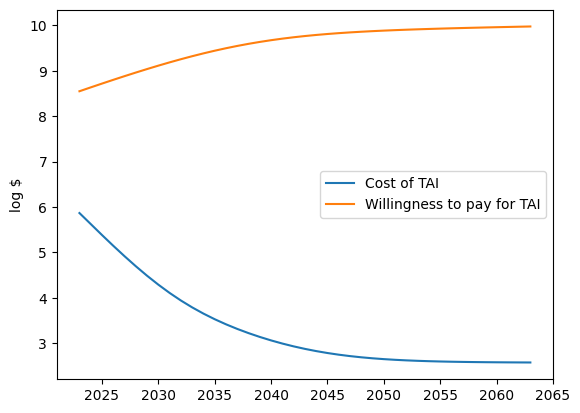

-
-
## SAMPLE RUN 49 ##
It takes 32.7 log FLOP (~501 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~175 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~123 million). This doubles every 4.7 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 26.4 max log FLOP (230 septillion) available - TAI takes 32.7 log FLOP (501 nonillion) - log $ 14.4 to buy TAI (262 trillion) vs. willingness to pay log $ 8.1 (121 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.4)
Year: 2024 - 26.6 max log FLOP (362 septillion) available - TAI takes 32.6 log FLOP (359 nonillion) - log $ 14.1 to buy TAI (139 trillion) vs. willingness to pay log $ 8.1 (140 million) - 18.4 log FLOP per $ (

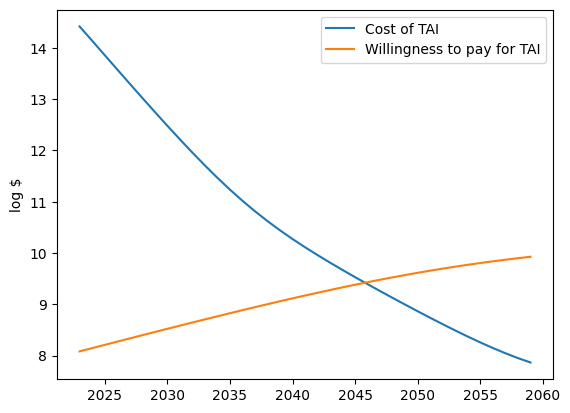

-
-
## SAMPLE RUN 50 ##
It takes 29.2 log FLOP (~158 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5 quintillion) per 2022$USD. Every 1.7 years they get 2x cheaper, to a maximum of 26.0 log FLOP (~112 septillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~249 million). This doubles every 3.8 years to a max of 0.138804% of GDP (initially ~32 billion 2022$USD). GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 29.2 log FLOP (158 octillion) - log $ 10.5 to buy TAI (34 billion) vs. willingness to pay log $ 8.4 (247 million) - 18.7 log FLOP per $ (5 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 29.1 log FLOP (127 octillion) - log $ 10.3 to buy TAI (18 billion) vs. willingness to pay log $ 8.5 (296 million) - 18.8 log FLOP per $ (7 quin

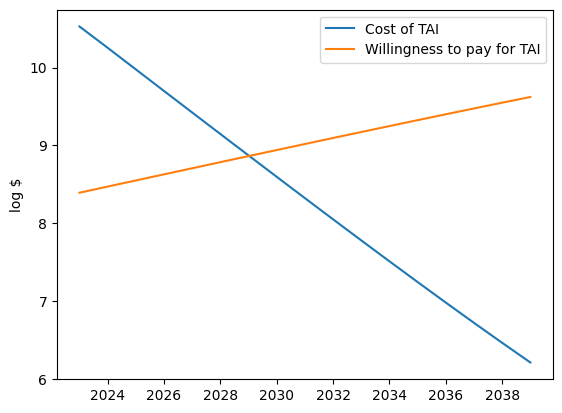

-
-
## SAMPLE RUN 51 ##
It takes 37.0 log FLOP (~10 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~3 quintillion) per 2022$USD. Every 4.4 years they get 2x cheaper, to a maximum of 25.4 log FLOP (~24 septillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~591 million). This doubles every 2.4 years to a max of 0.040427% of GDP (initially ~9 billion 2022$USD). GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 27.2 max log FLOP (1 octillion) available - TAI takes 37.0 log FLOP (10 thousand decillion) - log $ 18.6 to buy TAI (4 quintillion) vs. willingness to pay log $ 8.7 (556 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.4 max log FLOP (2 octillion) available - TAI takes 36.7 log FLOP (5 thousand decillion) - log $ 18.2 to buy TAI (2 quintillion) vs. willingness to pay log $ 8.9 (729 million) - 

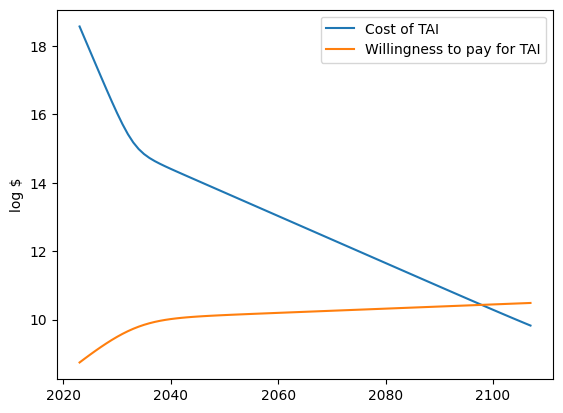

-
-
## SAMPLE RUN 52 ##
It takes 28.6 log FLOP (~40 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 1.0 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~211 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~498 million). This doubles every 2.0 years to a max of 0.398874% of GDP (initially ~92 billion 2022$USD). GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 28.6 log FLOP (40 octillion) - log $ 10.1 to buy TAI (11 billion) vs. willingness to pay log $ 8.7 (496 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.7 max log FLOP (5 octillion) available - TAI takes 28.5 log FLOP (32 octillion) - log $ 9.7 to buy TAI (4 billion) vs. willingness to pay log $ 8.8 (698 million) - 18.9 log FLOP per $ (7 quintilli

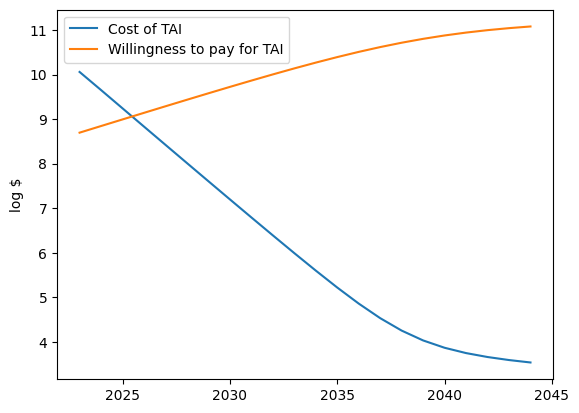

-
-
## SAMPLE RUN 53 ##
It takes 27.1 log FLOP (~1 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.0 log FLOP (~10 quintillion) per 2022$USD. Every 1.5 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~310 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~123 million). This doubles every 1.0 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 27.1 log FLOP (1 octillion) - log $ 8.1 to buy TAI (122 million) vs. willingness to pay log $ 8.1 (121 million) - 19.0 log FLOP per $ (10 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.6 max log FLOP (4 octillion) available - TAI takes 27.0 log FLOP (1 octillion) - log $ 7.8 to buy TAI (62 million) vs. willingness to pay log $ 8.4 (238 million) - 19.2 log FLOP per $ (16 quintillion) (

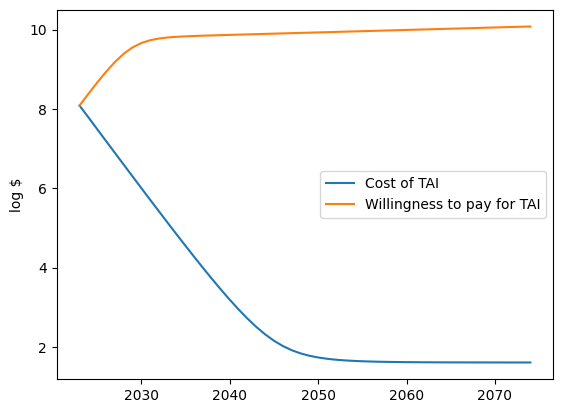

In [10]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)

In [11]:
print('File last ran: {}'.format(dt.now()))

File last ran: 2023-09-25 10:39:12.093246
